## 1. SET-UP

In [2]:
import pandas as pd
import json
import os

In [3]:
# 1. Load JSON files for each term
def load_mep_data(json_path):
    """Load MEP data from a JSON file."""
    print(f"Loading MEP data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"File not found: {json_path}")
        exit(1)
    
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            file_content = f.read().strip()  # Strip any extra whitespace
            if not file_content:
                raise ValueError("File is empty")
            
            # Validate JSON by loading
            meps_data = json.loads(file_content)  
            print(f"Loaded {len(meps_data)} MEPs successfully.")
            return meps_data
    
    except json.JSONDecodeError as e:
        print(f"JSON decode error at character {e.pos}: {e}")
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"Failed to load MEP data: {e}")
    exit(1)

# File paths (replace with your paths)
data_9th_term = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final national party merged/FINAL_cleaned_9-10term.json')
data_10th_term = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/national party, 10-11-2024/mep_assistants_national_party.json')

# Convert data to DataFrame
df_9th = pd.json_normalize(data_9th_term)
df_9th['term'] = 9  # Add term info
df_10th = pd.json_normalize(data_10th_term)
df_10th['term'] = 10

# Concatenate dataframes
all_meps = pd.concat([df_9th, df_10th], ignore_index=True)
print(all_meps.columns)

Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final national party merged/FINAL_cleaned_9-10term.json
Loaded 739 MEPs successfully.
Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/national party, 10-11-2024/mep_assistants_national_party.json
Loaded 719 MEPs successfully.
Index(['name', 'group', 'country', 'national_party', 'date_scraped',
       'assistants.Accredited assistants', 'assistants.Local assistants',
       'assistants.Service providers', 'assistants.Paying agents',
       'assistants.Accredited assistants (grouping)',
       'assistants.Local assistants (grouping)', 'assistants.Trainees',
       'assistants.Paying agents (grouping)', 'term', 'mep_group',
       'mep_national_party', 'assistants.Assistants to the Quaestorate',
       'assistants.Assistants to the Vice-Presidency'],
      dtype='object')


In [4]:
# Merge 'mep_group' and 'group'
all_meps['group'] = all_meps['mep_group'].combine_first(all_meps['group'])

# Merge 'mep_national_party' and 'national_party'
all_meps['national_party'] = all_meps['mep_national_party'].combine_first(all_meps['national_party'])

# Drop the redundant columns after merging
all_meps.drop(columns=['mep_group', 'mep_national_party'], inplace=True)

# Check the updated DataFrame
print(all_meps.tail())

                            name  \
1453           Nicola ZINGARETTI   
1454             Kosma ZŁOTOWSKI   
1455  Juan Ignacio ZOIDO ÁLVAREZ   
1456               Željana ZOVKO   
1457                  Milan ZVER   

                                                  group   country  \
1453  Group of the Progressive Alliance of Socialist...     Italy   
1454        European Conservatives and Reformists Group    Poland   
1455  Group of the European People's Party (Christia...     Spain   
1456  Group of the European People's Party (Christia...   Croatia   
1457  Group of the European People's Party (Christia...  Slovenia   

                      national_party date_scraped  \
1453             Partito Democratico          NaN   
1454          Prawo i Sprawiedliwość          NaN   
1455                 Partido Popular          NaN   
1456  Hrvatska demokratska zajednica          NaN   
1457   Slovenska demokratska stranka          NaN   

                       assistants.Accredited assi

In [5]:
# keep only columns that we will use in analysis
columns_to_keep = [
    'name',
    'national_party', 
    'group', 
    'country', 
    'term', 
    'assistants.Accredited assistants', 
    'assistants.Accredited assistants (grouping)'
]

# filter the DataFrame
meps_apas = all_meps[columns_to_keep]

# rename the columns by removing the 'assistants.' prefix
meps_apas.columns = [col.replace('assistants.', '') for col in meps_apas.columns]

print(meps_apas.columns)

Index(['name', 'national_party', 'group', 'country', 'term',
       'Accredited assistants', 'Accredited assistants (grouping)'],
      dtype='object')


# 2. CLEAN & STANDARDIZE

### 2.1 Party names to abbreviations

In [6]:
# Create a mapping dictionary for party names to abbreviations
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NI',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'Patriots',
    'Europe of Sovereign Nations Group': 'ESN'
}

meps_apas.loc[:, 'group_abbr'] = meps_apas['group'].map(group_abbreviations)
#print(meps_apas['national_party'].unique())
print(meps_apas['group_abbr'].unique())
# #print(meps_apas.columns)

# Iterate through the rows of the DataFrame
for index, row in meps_apas.iterrows():
    if pd.isna(row['group_abbr']):
        print(row['name'])


['Renew' 'ECR' 'EPP' 'S&D' 'ID' 'G/EFA' 'GUE/NGL' 'NI' 'ESN' 'Patriots']


C:\Users\Emilia\AppData\Local\Temp\ipykernel_11624\4206155982.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meps_apas.loc[:, 'group_abbr'] = meps_apas['group'].map(group_abbreviations)


### 2.3 Flatten & pivot (assistants are row level)

In [7]:
# Function to extract relevant assistants with type information
def extract_assistants(row):
    assistants = []
    # Define relevant groups and their corresponding types
    assistant_groups = {
        'Accredited assistants': 'accredited',
        'Accredited assistants (grouping)': 'accredited_grouping'
    }
    
    for group, assistant_type in assistant_groups.items():
        # Check if the group exists in the row and is a list
        if group in row and isinstance(row[group], list):
            for name in row[group]:
                assistants.append({
                    'assistant_name': name,
                    'mep_name': row['name'],
                    'group_full': row['group'],
                    'group_abbr': row['group_abbr'],
                    'mep_party': row['national_party'],
                    'country': row['country'],
                    'term': row['term'],
                    'assistant_type': assistant_type  # Add assistant type
                })
    return assistants

# Flatten assistants for easier comparison
assistant_data = pd.DataFrame(
    [item for sublist in meps_apas.apply(extract_assistants, axis=1) for item in sublist]
)
print(assistant_data)

                         assistant_name         mep_name  \
0                 Anna Sophia BENGTSSON  Abir AL-SAHLANI   
1               John August HULTENGAARD  Abir AL-SAHLANI   
2                  Tyra Louise LUNDBERG  Abir AL-SAHLANI   
3     Linn Christina Brunhilde OETTERLI  Abir AL-SAHLANI   
4               Sylwia Joanna BETKOWSKA     Adam JARUBAS   
...                                 ...              ...   
7067          Andréa Laure Marie MOULIN    Željana ZOVKO   
7068                         Polona KEK       Milan ZVER   
7069                     Petra SKRINJAR       Milan ZVER   
7070                        Peter SUHEL       Milan ZVER   
7071                     Dominik STRAKL       Milan ZVER   

                                             group_full group_abbr  \
0                                    Renew Europe Group      Renew   
1                                    Renew Europe Group      Renew   
2                                    Renew Europe Group      Renew   

### 2.3 Remove duplicate assistant names in same term

In [8]:
# FIRST REMAP THE NAMES
from fuzzywuzzy import fuzz

def find_similar_names(df, same_term=True):
    similar_pairs = []

    # Iterate through each MEP
    for mep in df['mep_name'].unique():
        # Filter for the current MEP
        if same_term:
            mep_data = df[df['mep_name'] == mep]
        else:
            mep_data = df[df['mep_name'] == mep]  # No term filter for this case

        # Check if the DataFrame contains 'term' column
        term = mep_data['term'].iloc[0] if 'term' in mep_data.columns else "Unknown term"

        names = mep_data['assistant_name'].tolist()

        # Check for similarity between each pair of assistant names
        for i in range(len(names)):
            for j in range(i + 1, len(names)):
                # Calculate similarity score
                score = fuzz.ratio(names[i].lower(), names[j].lower())
                
                # Adjusting the threshold between 90 and 99
                if 75 <= score < 100:  # Use the desired range here
                    similar_pairs.append((names[i], names[j], mep, term))

    return similar_pairs

# Find similar names considering only the same term
#similar_names_same_term = find_similar_names(assistant_data, same_term=True)
#print("Similar assistant names for the same MEP in the same term:")
#for name1, name2, mep in similar_names_same_term:
#    print(f"{name1} and {name2} for {mep} are similar.")

# create remapping based on similar names
name_mapping = {
    "Magdalena NOWACKA": "Magdalena HILLS-NOWACKA", 
    "PAULA SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "Eleonora Nikolaycheva GUIGOVA": "Eleonora Nikolaycheva GUIGOVA-NOSKER",
    "Eleonora Nikolaycheva GUIGOVA-NOSKER": "Eleonora Nikolaycheva GUIGOVA-NOSKER",
    "Stefanie SIFFT": "Stefanie SIFFT",
    "Stefanie Gabi SIFFT": "Stefanie SIFFT",
    "Anne-Cecile Juliette GAULT": "Anne-Cecile Juliette GAULT",
    "Anne-Cecile Juliette Rachel GAULT": "Anne-Cecile Juliette GAULT",
    "Sophie Anne Geraldine Marie GUIL": "Sophie Anne Geraldine Marie GUIL",
    "Sophie Anne Geraldine Marie Genevieve GUIL": "Sophie Anne Geraldine Marie GUIL",
    "Ana LOPEZ GONZALEZ": "ANA LÓPEZ GONZÁLEZ",
    "ANA LÓPEZ GONZÁLEZ": "ANA LÓPEZ GONZÁLEZ",
    "Claudia MARTINEZ MUNOZ": "Claudia MARTÍNEZ MUÑOZ",
    "CLAUDIA MARTÍNEZ MUÑOZ": "Claudia MARTÍNEZ MUÑOZ",
    "Maria Mercedes GARCIA MUNOZ": "MARIA MERCEDES GARCIA MUÑOZ",
    "MARIA MERCEDES GARCIA MUÑOZ": "MARIA MERCEDES GARCIA MUÑOZ",
    "Gilles Willy B SEGERS": "GILLES WILLY SEGERS",
    "GILLES WILLY SEGERS": "GILLES WILLY SEGERS",
    "Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "Maria Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "Arturo VILLARROYA GONZALEZ": "Arturo VILLARROYA GONZÁLEZ",
    "Fernando Jose NUNEZ ROBRES PATINO": "Fernando Jose NUNEZ-ROBRES PATINO",
    "Fernando Jose NUNEZ-ROBRES PATINO": "Fernando Jose NUNEZ-ROBRES PATINO",
    "Bibiana CARRETO PEREZ BARBADILLO": "BIBIANA CARRETO PÉREZ BARBADILLO",
    "BIBIANA CARRETO PÉREZ BARBADILLO": "BIBIANA CARRETO PÉREZ BARBADILLO",
    "Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "PAULA SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "Paula SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "MARIA MERCEDES GARCIA MUNOZ": "MARIA MERCEDES GARCIA MUÑOZ", 
    "ARTURO VILLARROYA GONZALEZ": "Arturo VILLARROYA GONZÁLEZ",
    "ARTURO VILLARROYA GONZALEZ":"Arturo VILLARROYA GONZÁLEZ", 
    "Marlene Elisabeth SEELMAIER": "Marlene Elisabeth STROEHM",          # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term 
    "Olivia Jeanna Beatrice ANDERSSON": "Olivia Jeanna Beatrice STÅNGE", # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term
    "Sirle ROSENFELDT": "Sirle ROSENFELDT - KOOP",                       # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term
    "Saara ANTTINEN": "Saara ANTTINEN-KHUMALO",                          # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term
    "Nikolina BRKOVIC": "Nikolina BRKOVIC STANCHEVA", 
    "Josep/Pepe MERCADAL BAQUERO": "Pepe MERCADAL BAQUERO",               # CHANGED HIS NAME TO PEPE
    "Josep MERCADAL BAQUERO": "Pepe MERCADAL BAQUERO" 
}

# remap 
assistant_data['assistant_name'] = assistant_data['assistant_name'].replace(name_mapping)

# check that name remapping worked
# Find similar names considering only the same term
similar_names_same_term = find_similar_names(assistant_data, same_term=True)
print("Similar assistant names for the same MEP in the same term:")
for name1, name2, mep, term in similar_names_same_term:
    print(f"{name1} and {name2} for {mep} in term {term} are similar.")

Similar assistant names for the same MEP in the same term:
Silvia RIGHI and SILVIA DRAGONI for Elisabetta GUALMINI in term 9 are similar.
Silvia RIGHI and SILVIA DRAGONI for Elisabetta GUALMINI in term 9 are similar.
Dirk FRIEDRICH and Pierre FRIEDRICH for Jörg MEUTHEN in term 9 are similar.
Jakub PUSZKARSKI and Jakub KARWANSKI for Magdalena ADAMOWICZ in term 9 are similar.
Michal MOJTO and Michaela MOJTOVÁ for Monika BEŇOVÁ in term 9 are similar.
CARLOS CAMPILLO PEREZ and IGNACIO CAMPILLO PEREZ for Margarita DE LA PISA CARRIÓN in term 9 are similar.
CARLOS CAMPILLO PEREZ and IGNACIO CAMPILLO PEREZ for Margarita DE LA PISA CARRIÓN in term 9 are similar.
Elena MATO MALDONADO and Elena MARTIN ALONSO for Rosa ESTARÀS FERRAGUT in term 9 are similar.
CARLOS CAMPILLO PEREZ and IGNACIO CAMPILLO PEREZ for Jorge BUXADÉ VILLALBA in term 9 are similar.
CARLOS CAMPILLO PEREZ and IGNACIO CAMPILLO PEREZ for Jorge BUXADÉ VILLALBA in term 9 are similar.
CARLOS CAMPILLO PEREZ and IGNACIO CAMPILLO PEREZ

In [9]:
# THEN REMOVE ANY EXACT MATCHES 
# Find exact matches within each MEP and term
def find_exact_matches(df):
    exact_matches = {}

    # Group by 'mep_name' and 'term' and find duplicates in 'assistant_name'
    for (mep, term), group in df.groupby(['mep_name', 'term']):
        # Normalize names by stripping whitespace and converting to lowercase
        normalized_names = group['assistant_name'].str.strip().str.lower()
        
        # Count occurrences of each normalized name
        duplicates = normalized_names.value_counts()
        
        # Only keep names that occur more than once
        duplicate_names = duplicates[duplicates > 1].index.tolist()
        
        if duplicate_names:
            exact_matches[(mep, term)] = duplicate_names

    return exact_matches

# Get exact matches
exact_matches = find_exact_matches(assistant_data)

# Print out exact matches
print("Exact matches in MEP categories (for the same term):")
for (mep, term), names in exact_matches.items():
    print(f"\nMEP: {mep} | Term: {term}")
    for name in names:
        print(f" - {name}")

# remove duplicates 
unique_apas = assistant_data.drop_duplicates(subset=['mep_name', 'term', 'assistant_name'])
#print(unique_meps_apas)


Exact matches in MEP categories (for the same term):

MEP: Alicia HOMS GINEL | Term: 9
 - daniel diez cecilia
 - alberto bondesio martinez
 - cristian villar prieto
 - elena pereda lagartos
 - joan serra mingot
 - pepe mercadal baquero
 - maria magdalena gonzalez gozalbo
 - laura ballarin cereza
 - alejandro peinado garcia
 - jose antonio espejo gutierrez
 - ignacio santiago del olmo tejerina
 - xose anton dios marino
 - irina de sancho alonso
 - eduardo blanco buzon
 - izaskun bernal cerdeira
 - ana isabel esteban tortola
 - annika lotson lopez
 - andrea maceiras castro
 - mercedes mariscal campos
 - maria isabel meireles de andrade
 - isabel garcia tamara
 - carla gonzalez ricarte
 - maria jesus gallego estremera
 - francisco javier gallego amador
 - sonia maria sanchez gomez
 - maria eugenia romano martinez
 - pablo pintos tourino
 - maria lourdes minchot ballarin
 - aranzazu tarazona huerta
 - eva pilar sanjuan guerrero
 - marina sola garcia
 - maria luisa sevilla andrada
 - julia 

In [10]:
# Replace values in the 'country' column
unique_apas['country'].replace({'PSC-PSOE': 'Spain', 'PNCR': 'Romania'}, inplace=True)

# Check the updated values in the 'country' column
print(unique_apas['country'].nunique())

28


C:\Users\Emilia\AppData\Local\Temp\ipykernel_11624\912274407.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unique_apas['country'].replace({'PSC-PSOE': 'Spain', 'PNCR': 'Romania'}, inplace=True)
C:\Users\Emilia\AppData\Local\Temp\ipykernel_11624\912274407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_apas['country'].replace({

In [21]:
# save unique mep names to an excel
unique_apas.to_excel('assistants_all.xlsx', index=False, engine='openpyxl')

# 3. Summary Statistics

In [14]:
# Step 1: Filter data for Term 9 and Term 10
term_9_df = unique_apas[unique_apas['term'] == 9]
term_10_df = unique_apas[unique_apas['term'] == 10]

# Step 2: Find assistants who appear in both terms
assistants_both_terms = pd.merge(
    term_9_df[['assistant_name', 'mep_name', 'group_abbr']],
    term_10_df[['assistant_name', 'mep_name', 'group_abbr']],
    on='assistant_name',
    suffixes=('_term_9', '_term_10')
)

# Step 3: Determine continuity with the same or different MEP
# Check if the MEP name stayed the same
same_mep = assistants_both_terms[assistants_both_terms['mep_name_term_9'] == assistants_both_terms['mep_name_term_10']]
moved_mep = assistants_both_terms[assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']]

# Step 4: Group by 'group_abbr' and count
same_mep_group_count = same_mep.groupby('group_abbr_term_9').size().reset_index(name='same_mep_count')
moved_mep_group_count = moved_mep.groupby('group_abbr_term_9').size().reset_index(name='moved_mep_count')

# Step 5: Merge the results for better comparison
group_comparison = pd.merge(
    same_mep_group_count,
    moved_mep_group_count,
    on='group_abbr_term_9',
    how='outer'
).fillna(0)

# Rename the column for clarity
group_comparison.rename(columns={'group_abbr_term_9': 'group_abbr'}, inplace=True)

# Output the results# Step 1: Filter data for Term 9 and Term 10
term_9_df = unique_apas[unique_apas['term'] == 9]
term_10_df = unique_apas[unique_apas['term'] == 10]

# Step 2: Merge data to find assistants present in both terms
assistants_both_terms = pd.merge(
    term_9_df[['assistant_name', 'mep_name', 'group_abbr']],
    term_10_df[['assistant_name', 'mep_name', 'group_abbr']],
    on='assistant_name',
    suffixes=('_term_9', '_term_10')
)

# Step 3: Determine types of movement
# Assistants who stayed with the same MEP
same_mep = assistants_both_terms[assistants_both_terms['mep_name_term_9'] == assistants_both_terms['mep_name_term_10']]

# Assistants who moved to a different MEP but within the same party
moved_same_party = assistants_both_terms[
    (assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']) &
    (assistants_both_terms['group_abbr_term_9'] == assistants_both_terms['group_abbr_term_10'])
]

# Assistants who moved to a different MEP and different party
moved_different_party = assistants_both_terms[
    (assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']) &
    (assistants_both_terms['group_abbr_term_9'] != assistants_both_terms['group_abbr_term_10'])
]

# Step 4: Group by 'group_abbr' and count each type
same_mep_count = same_mep.groupby('group_abbr_term_9').size().reset_index(name='same_mep_count')
moved_same_party_count = moved_same_party.groupby('group_abbr_term_9').size().reset_index(name='moved_same_party_count')
moved_different_party_count = moved_different_party.groupby('group_abbr_term_9').size().reset_index(name='moved_different_party_count')

# Step 5: Merge the counts
movement_summary = same_mep_count.merge(moved_same_party_count, on='group_abbr_term_9', how='outer').merge(
    moved_different_party_count, on='group_abbr_term_9', how='outer'
).fillna(0)

# Rename column for clarity
movement_summary.rename(columns={'group_abbr_term_9': 'group_abbr'}, inplace=True)

# Calculate percentages for each movement type
total_movement = movement_summary['moved_same_party_count'] + movement_summary['moved_different_party_count']
movement_summary['moved_same_party_pct'] = (movement_summary['moved_same_party_count'] / total_movement * 100).round(2)
movement_summary['moved_different_party_pct'] = (movement_summary['moved_different_party_count'] / total_movement * 100).round(2)

# Step 6: Analyze where assistants moved to (similar or different ideology)
movement_different_party = pd.merge(
    moved_different_party[['assistant_name', 'group_abbr_term_9', 'group_abbr_term_10']],
    unique_apas[['group_abbr', 'mep_party']].drop_duplicates(),
    left_on='group_abbr_term_10',
    right_on='group_abbr'
)

# Output the main movement summary table
movement_summary

,group_abbr,same_mep_count,moved_same_party_count,moved_different_party_count,moved_same_party_pct,moved_different_party_pct
0,ECR,42,35.0,119,22.73,77.27
1,EPP,124,413.0,26,94.08,5.92
2,G/EFA,66,111.0,4,96.52,3.48
3,GUE/NGL,24,13.0,29,30.95,69.05
4,ID,24,0.0,119,0.00,100.00
5,NI,10,6.0,13,31.58,68.42
6,Renew,43,22.0,39,36.07,63.93
7,S&D,287,3965.0,15,99.62,0.38


In [25]:
import pandas as pd

# Step 1: Filter data for Term 9 and Term 10
term_9_df = unique_apas[unique_apas['term'] == 9]
term_10_df = unique_apas[unique_apas['term'] == 10]

# Step 2: Calculate total assistants in Term 9 and Term 10
total_term_9_assistants = term_9_df['assistant_name'].nunique()
total_term_10_assistants = term_10_df['assistant_name'].nunique()

# Step 3: Calculate the total unique assistants across both terms
total_unique_assistants = pd.concat([term_9_df['assistant_name'], term_10_df['assistant_name']]).nunique()

# Step 4: Find assistants who appear in both terms
assistants_both_terms = pd.merge(
    term_9_df[['assistant_name', 'mep_name']],
    term_10_df[['assistant_name', 'mep_name']],
    on='assistant_name',
    suffixes=('_term_9', '_term_10')
)
total_both_terms = assistants_both_terms['assistant_name'].nunique()

# Step 5: Determine continuity with the same or different MEP
same_mep = assistants_both_terms[assistants_both_terms['mep_name_term_9'] == assistants_both_terms['mep_name_term_10']]
moved_mep = assistants_both_terms[assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']]

same_mep_count = same_mep.shape[0]
moved_mep_count = moved_mep.shape[0]

# Step 6: Create a summary table
summary_data = {
    'Category': [
        'Total Assistants in Term 9',
        'Total Assistants in Term 10',
        'Total Unique Assistants (Term 9 and Term 10)',
        'Total Assistants in Both Terms (9 and 10)',
        'Stayed with the Same MEP',
        'Moved to a Different MEP'
    ],
    'Count': [
        total_term_9_assistants,
        total_term_10_assistants,
        total_unique_assistants,
        total_both_terms,
        same_mep_count,
        moved_mep_count
    ]
}

# Convert the summary data into a DataFrame
summary_df = pd.DataFrame(summary_data)

# Output the summary table
summary_df

,Category,Count
0,Total Assistants in Term 9,1805
1,Total Assistants in Term 10,1990
2,Total Unique Assistants (Term 9 and Term 10),3139
3,Total Assistants in Both Terms (9 and 10),656
4,Stayed with the Same MEP,620
5,Moved to a Different MEP,4929


In [27]:
import pandas as pd

# Step 1: Filter data for Term 9 and Term 10
term_9_df = unique_apas[unique_apas['term'] == 9]
term_10_df = unique_apas[unique_apas['term'] == 10]

# Step 2: Calculate total assistants in Term 9 and Term 10
total_term_9_assistants = term_9_df['assistant_name'].nunique()
total_term_10_assistants = term_10_df['assistant_name'].nunique()

# Step 3: Calculate the total unique assistants across both terms
total_unique_assistants = pd.concat([term_9_df['assistant_name'], term_10_df['assistant_name']]).nunique()

# Step 4: Find assistants who appear in both terms
assistants_both_terms = pd.merge(
    term_9_df[['assistant_name', 'mep_name']],
    term_10_df[['assistant_name', 'mep_name']],
    on='assistant_name',
    suffixes=('_term_9', '_term_10')
)
total_both_terms = assistants_both_terms['assistant_name'].nunique()

# Step 5: Determine assistants who were only in Term 9
assistants_only_in_term_9 = term_9_df[~term_9_df['assistant_name'].isin(term_10_df['assistant_name'])]

# Total count of assistants only in Term 9 (including duplicates)
total_only_in_term_9_count = assistants_only_in_term_9.shape[0]

# Unique count of assistants only in Term 9
unique_only_in_term_9_count = assistants_only_in_term_9['assistant_name'].nunique()

# Step 6: Create a summary table
summary_data = {
    'Category': [
        'Total Assistants in Term 9',
        'Total Assistants in Term 10',
        'Total Unique Assistants (Term 9 and Term 10)',
        'Total Assistants in Both Terms (9 and 10)',
        'Total Assistants Only in Term 9 (Including Duplicates)',
        'Unique Assistants Only in Term 9'
    ],
    'Count': [
        total_term_9_assistants,
        total_term_10_assistants,
        total_unique_assistants,
        total_both_terms,
        total_only_in_term_9_count,
        unique_only_in_term_9_count
    ]
}

# Convert the summary data into a DataFrame
summary_df = pd.DataFrame(summary_data)

# Output the summary table
summary_df

,Category,Count
0,Total Assistants in Term 9,1805
1,Total Assistants in Term 10,1990
2,Total Unique Assistants (Term 9 and Term 10),3139
3,Total Assistants in Both Terms (9 and 10),656
4,Total Assistants Only in Term 9 (Including Dup...,1590
5,Unique Assistants Only in Term 9,1149


In [28]:
# Step 1: Filter data for Term 9 and Term 10
term_9_df = unique_apas[unique_apas['term'] == 9]
term_10_df = unique_apas[unique_apas['term'] == 10]

# Step 2: Merge data to find assistants present in both terms
assistants_both_terms = pd.merge(
    term_9_df[['assistant_name', 'mep_name', 'group_abbr']],
    term_10_df[['assistant_name', 'mep_name', 'group_abbr']],
    on='assistant_name',
    suffixes=('_term_9', '_term_10')
)

# Step 3: Determine types of movement
# Assistants who stayed with the same MEP
same_mep = assistants_both_terms[assistants_both_terms['mep_name_term_9'] == assistants_both_terms['mep_name_term_10']]

# Assistants who moved to a different MEP but within the same party
moved_same_party = assistants_both_terms[
    (assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']) &
    (assistants_both_terms['group_abbr_term_9'] == assistants_both_terms['group_abbr_term_10'])
]

# Assistants who moved to a different MEP and different party
moved_different_party = assistants_both_terms[
    (assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']) &
    (assistants_both_terms['group_abbr_term_9'] != assistants_both_terms['group_abbr_term_10'])
]

# Step 4: Group by 'group_abbr' and count each type
same_mep_count = same_mep.groupby('group_abbr_term_9').size().reset_index(name='same_mep_count')
moved_same_party_count = moved_same_party.groupby('group_abbr_term_9').size().reset_index(name='moved_same_party_count')
moved_different_party_count = moved_different_party.groupby('group_abbr_term_9').size().reset_index(name='moved_different_party_count')

# Step 5: Merge the counts
movement_summary = same_mep_count.merge(moved_same_party_count, on='group_abbr_term_9', how='outer').merge(
    moved_different_party_count, on='group_abbr_term_9', how='outer'
).fillna(0)

# Rename column for clarity
movement_summary.rename(columns={'group_abbr_term_9': 'group_abbr'}, inplace=True)

# Calculate percentages for each movement type
total_movement = movement_summary['moved_same_party_count'] + movement_summary['moved_different_party_count']
movement_summary['moved_same_party_pct'] = (movement_summary['moved_same_party_count'] / total_movement * 100).round(2)
movement_summary['moved_different_party_pct'] = (movement_summary['moved_different_party_count'] / total_movement * 100).round(2)

# Step 6: Analyze where assistants moved to (similar or different ideology)
movement_different_party = pd.merge(
    moved_different_party[['assistant_name', 'group_abbr_term_9', 'group_abbr_term_10']],
    unique_apas[['group_abbr', 'mep_party']].drop_duplicates(),
    left_on='group_abbr_term_10',
    right_on='group_abbr'
)

# Output the main movement summary table
movement_summary


,group_abbr,same_mep_count,moved_same_party_count,moved_different_party_count,moved_same_party_pct,moved_different_party_pct
0,ECR,42,35.0,119,22.73,77.27
1,EPP,124,413.0,26,94.08,5.92
2,G/EFA,66,111.0,4,96.52,3.48
3,GUE/NGL,24,13.0,29,30.95,69.05
4,ID,24,0.0,119,0.00,100.00
5,NI,10,6.0,13,31.58,68.42
6,Renew,43,22.0,39,36.07,63.93
7,S&D,287,3965.0,15,99.62,0.38


In [22]:
# Step 1: Filter assistants who worked for the ID group in Term 9
id_term_9 = assistants_both_terms[assistants_both_terms['group_abbr_term_9'] == 'ID']

# Step 2: Count those who stayed within the ID group in Term 10
stayed_in_id_count = id_term_9[id_term_9['group_abbr_term_10'] == 'ID'].shape[0]

# Step 3: Count those who moved to a different party in Term 10
moved_from_id = id_term_9[id_term_9['group_abbr_term_10'] != 'ID']
moved_from_id_total = moved_from_id.shape[0]

# Step 4: Group by the destination group and count
moved_from_id_count = moved_from_id.groupby('group_abbr_term_10').size().reset_index(name='count')

# Step 5: Calculate the total number of assistants from ID and the percentages
total_id_assistants = id_term_9.shape[0]
stayed_in_id_pct = (stayed_in_id_count / total_id_assistants) * 100
moved_from_id_pct = (moved_from_id_total / total_id_assistants) * 100

# Add percentage column to the movement table
moved_from_id_count['percentage'] = (moved_from_id_count['count'] / total_id_assistants) * 100

# Step 6: Create a summary table
id_summary = pd.DataFrame({
    'category': ['Stayed in ID', 'Moved to another group'],
    'count': [stayed_in_id_count, moved_from_id_total],
    'percentage': [stayed_in_id_pct, moved_from_id_pct]
})

# Output the summary and detailed movement tables
id_summary, moved_from_id_count

(                 category  count  percentage
 0            Stayed in ID      0         0.0
 1  Moved to another group    143       100.0,
   group_abbr_term_10  count  percentage
 0                ECR     16   11.188811
 1                EPP      1    0.699301
 2                ESN     13    9.090909
 3           Patriots    113   79.020979)

In [29]:
# Step 1: Filter data for Term 9 and Term 10
term_9_df = unique_apas[unique_apas['term'] == 9]
term_10_df = unique_apas[unique_apas['term'] == 10]

# Step 2: Merge data to find assistants present in both terms
assistants_both_terms = pd.merge(
    term_9_df[['assistant_name', 'mep_name', 'country']],
    term_10_df[['assistant_name', 'mep_name', 'country']],
    on='assistant_name',
    suffixes=('_term_9', '_term_10')
)

# Step 3: Determine types of movement
# Assistants who stayed with the same MEP
same_mep = assistants_both_terms[assistants_both_terms['mep_name_term_9'] == assistants_both_terms['mep_name_term_10']]

# Assistants who moved to a different MEP but stayed in the same country
moved_same_country = assistants_both_terms[
    (assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']) &
    (assistants_both_terms['country_term_9'] == assistants_both_terms['country_term_10'])
]

# Assistants who moved to a different MEP and a different country (uncommon, but let's check)
moved_different_country = assistants_both_terms[
    (assistants_both_terms['mep_name_term_9'] != assistants_both_terms['mep_name_term_10']) &
    (assistants_both_terms['country_term_9'] != assistants_both_terms['country_term_10'])
]

# Step 4: Group by 'country_term_9' and count each type
same_mep_count = same_mep.groupby('country_term_9').size().reset_index(name='same_mep_count')
moved_same_country_count = moved_same_country.groupby('country_term_9').size().reset_index(name='moved_same_country_count')
moved_different_country_count = moved_different_country.groupby('country_term_9').size().reset_index(name='moved_different_country_count')

# Step 5: Merge the counts
movement_summary_by_country = same_mep_count.merge(
    moved_same_country_count, on='country_term_9', how='outer'
).merge(
    moved_different_country_count, on='country_term_9', how='outer'
).fillna(0)

# Rename column for clarity
movement_summary_by_country.rename(columns={'country_term_9': 'country'}, inplace=True)

# Calculate percentages for each movement type
total_movement = (
    movement_summary_by_country['moved_same_country_count'] +
    movement_summary_by_country['moved_different_country_count']
)

# Avoid division by zero by filtering out cases with no movement
movement_summary_by_country['moved_same_country_pct'] = (movement_summary_by_country['moved_same_country_count'] / total_movement * 100).fillna(0)
movement_summary_by_country['moved_different_country_pct'] = (movement_summary_by_country['moved_different_country_count'] / total_movement * 100).fillna(0)

# Step 6: Output the main movement summary table by country
movement_summary_by_country


,country,same_mep_count,moved_same_country_count,moved_different_country_count,moved_same_country_pct,moved_different_country_pct
0,Austria,9.0,8.0,6.0,57.142857,42.857143
1,Belgium,16.0,19.0,0.0,100.000000,0.000000
2,Bulgaria,8.0,4.0,0.0,100.000000,0.000000
3,Croatia,2.0,2.0,0.0,100.000000,0.000000
4,Cyprus,5.0,1.0,3.0,25.000000,75.000000
5,Czechia,7.0,13.0,1.0,92.857143,7.142857
6,Denmark,1.0,0.0,0.0,0.000000,0.000000
7,Estonia,11.0,2.0,0.0,100.000000,0.000000
8,Finland,6.0,2.0,0.0,100.000000,0.000000
9,France,47.0,102.0,10.0,91.071429,8.928571


# 4. Summary Tables

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for terms 9 and 10
term_data = unique_apas[unique_apas['term'].isin([9, 10])]

# Function to create transition matrix for a specific assistant type
def create_transition_matrix(assistant_type):
    # Step 1: Filter for the specific assistant type
    filtered_data = term_data[term_data['assistant_type'] == assistant_type]
    
    # Step 2: Get assistants for term 9 and term 10
    term_9 = filtered_data[filtered_data['term'] == 9]
    term_10 = filtered_data[filtered_data['term'] == 10]

    # Step 3: Merge both DataFrames on assistant_name
    merged = term_9[['assistant_name', 'group']].merge(term_10[['assistant_name', 'group']], on='assistant_name', suffixes=('_9', '_10'))

    # Step 4: Count transitions from term 9 to term 10
    transition_counts = merged.groupby(['group_9', 'group_10']).size().reset_index(name='counts')

    # Step 5: Create a transition matrix
    transition_matrix = transition_counts.pivot(index='group_9', columns='group_10', values='counts').fillna(0)

    # Optional: Convert counts to integers if needed
    transition_matrix = transition_matrix.astype(int)

    return transition_matrix

# Create transition matrices for both types of assistants
accredited_transition_matrix = create_transition_matrix('accredited')
accredited_grouping_transition_matrix = create_transition_matrix('accredited_grouping')

# Visualization of the Transition Matrix for Accredited Assistants
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Group Transition Matrix for Accredited Assistants (9th to 10th Term)')
plt.xlabel('Group in Term 10')
plt.ylabel('Group in Term 9')
plt.show()

# Visualization of the Transition Matrix for Accredited Assistants Grouping
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_grouping_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Group Transition Matrix for Accredited Assistants Grouping (9th to 10th Term)')
plt.xlabel('Group in Term 10')
plt.ylabel('Group in Term 9')
plt.show()

KeyError: "['group'] not in index"

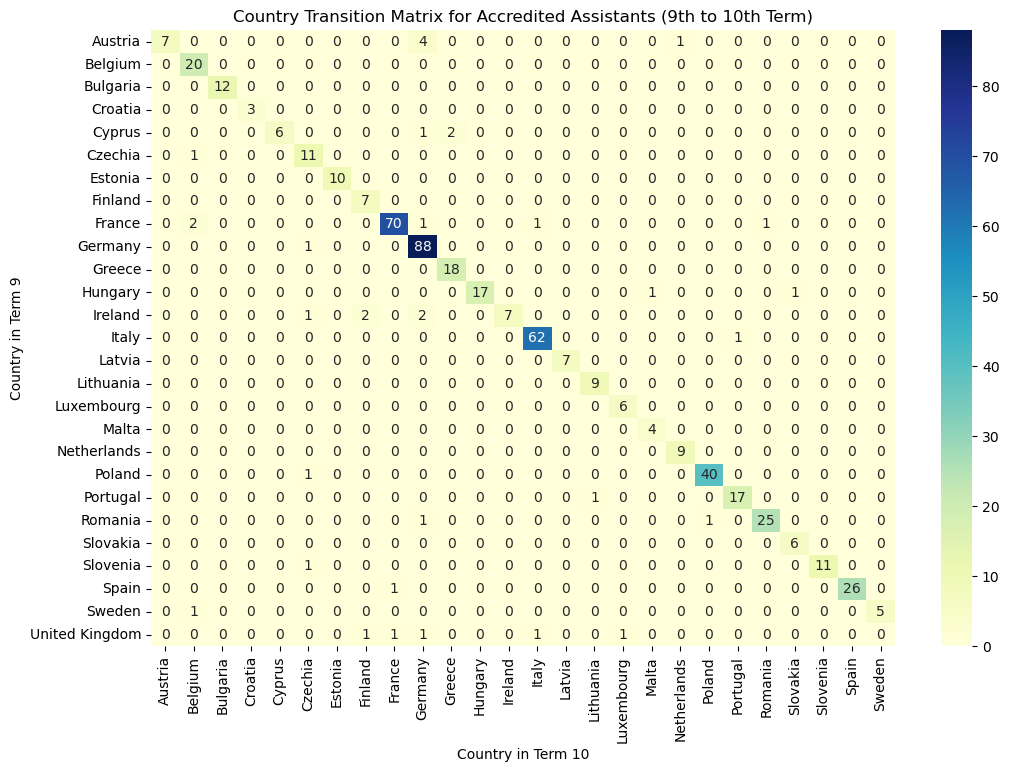

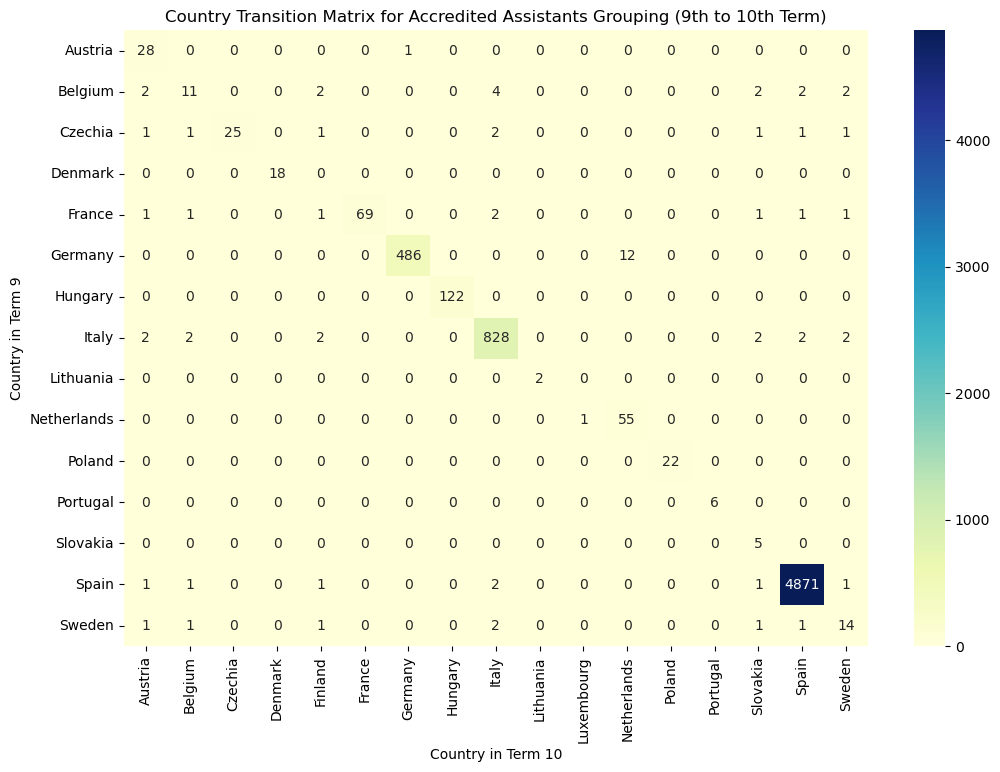

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for terms 9 and 10
term_data = unique_apas[unique_apas['term'].isin([9, 10])]

# Function to create country transition matrix for a specific assistant type
def create_country_transition_matrix(assistant_type):
    # Step 1: Filter for the specific assistant type
    filtered_data = term_data[term_data['assistant_type'] == assistant_type]
    
    # Step 2: Get assistants for term 9 and term 10
    term_9 = filtered_data[filtered_data['term'] == 9]
    term_10 = filtered_data[filtered_data['term'] == 10]

    # Step 3: Merge both DataFrames on assistant_name
    merged = term_9[['assistant_name', 'country']].merge(term_10[['assistant_name', 'country']], on='assistant_name', suffixes=('_9', '_10'))

    # Step 4: Count transitions from term 9 to term 10
    transition_counts = merged.groupby(['country_9', 'country_10']).size().reset_index(name='counts')

    # Step 5: Create a transition matrix
    transition_matrix = transition_counts.pivot(index='country_9', columns='country_10', values='counts').fillna(0)

    # Optional: Convert counts to integers if needed
    transition_matrix = transition_matrix.astype(int)

    return transition_matrix

# Create transition matrices for both types of assistants
accredited_country_transition_matrix = create_country_transition_matrix('accredited')
accredited_grouping_country_transition_matrix = create_country_transition_matrix('accredited_grouping')

# Visualization of the Transition Matrix for Accredited Assistants
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_country_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Country Transition Matrix for Accredited Assistants (9th to 10th Term)')
plt.xlabel('Country in Term 10')
plt.ylabel('Country in Term 9')
plt.show()

# Visualization of the Transition Matrix for Accredited Assistants Grouping
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_grouping_country_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Country Transition Matrix for Accredited Assistants Grouping (9th to 10th Term)')
plt.xlabel('Country in Term 10')
plt.ylabel('Country in Term 9')
plt.show()

### 3.1 Summary of movement (b/w MEPs that were in both 9th and 10th term)

#### 3.1.1 Sanity Check

In [58]:
# Load data for both terms
SANITY_CHECK_9TERM = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json')
SANITY_CHECK_10TERM = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json')

# Initialize a dictionary to count total assistants
total_assistant_counts = {}

# Function to count assistants from the data
def count_assistants(data, term):
    for entry in data:
        party = entry["party"]
        assistants = entry.get("assistants", {})
        
        # Count accredited assistants
        accredited_count = len(assistants.get("Accredited assistants", [])) + len(assistants.get("Accredited assistants (grouping)", []))
        
        # Initialize party in dictionary if not already present
        if party not in total_assistant_counts:
            total_assistant_counts[party] = {"term_9": 0, "term_10": 0}
        
        # Update the count for the respective term
        if term == 9:
            total_assistant_counts[party]["term_9"] += accredited_count
        elif term == 10:
            total_assistant_counts[party]["term_10"] += accredited_count

# Count assistants for both terms
count_assistants(SANITY_CHECK_9TERM, term=9)
count_assistants(SANITY_CHECK_10TERM, term=10)

# Debugging: Print total assistants for each party
for party, counts in total_assistant_counts.items():
    print(f"Party: {party}, Term 9: {counts['term_9']}, Term 10: {counts['term_10']}")

Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json
Loaded 735 MEPs successfully.
Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json
Loaded 719 MEPs successfully.
Party: Renew Europe Group, Term 9: 310, Term 10: 315
Party: European Conservatives and Reformists Group, Term 9: 143, Term 10: 224
Party: Group of the European People's Party (Christian Democrats), Term 9: 751, Term 10: 1168
Party: Group of the Progressive Alliance of Socialists and Democrats in the European Parliament, Term 9: 1281, Term 10: 1446
Party: Identity and Democracy Group, Term 9: 139, Term 10: 0
Party: Group of the Greens/European Free Alliance, Term 9: 318, Term 10: 365
Party: Confederal Group of the European United Left - Nordic Green Left, Term 9: 49, Term 10: 0
Party: Non-attached Members, Term 9: 150, Term 10: 81


#### 3.1.2 Calculation

In [ ]:
# Filter the DataFrame for terms 9 and 10
term_9 = unique_apas[unique_apas['term'] == 9]
term_10 = unique_apas[unique_apas['term'] == 10]

# Group by MEP and group for each term to count assistants, ensuring unique combinations
term_9_grouped = term_9.groupby(['mep_name', 'group']).agg(assistant_count_9=('assistant_name', 'count')).reset_index()
term_10_grouped = term_10.groupby(['mep_name', 'group']).agg(assistant_count_10=('assistant_name', 'count')).reset_index()

# Merge the two dataframes on MEP name and group to create a transition table
transition_df = pd.merge(term_9_grouped, term_10_grouped, on=['mep_name', 'group'], how='outer')

# Create transition summary
transition_summary = []

# Loop through unique groups in term 9
for group_9 in transition_df['group'].unique():
    group_9_assistants = transition_df[transition_df['group'] == group_9]
    
    # Loop through unique groups in term 10
    for group_10 in transition_df['group'].unique():
        # Count how many moved from group_9 to group_10
        count = group_9_assistants['assistant_count_9'].sum() if (group_9_assistants['assistant_count_10'] > 0).any() else 0
        transition_summary.append({
            'group_9': group_9,
            'group_10': group_10,
            'counts': count
        })

# Remove rows with NaN in either assistant_count_9 or assistant_count_10
transition_df = transition_df.dropna(subset=['assistant_count_9', 'assistant_count_10'])

# Step 1: Calculate total assistants for each group in both terms
total_assistants_term_9 = transition_df.groupby('group')['assistant_count_9'].sum().reset_index()
total_assistants_term_9.rename(columns={'assistant_count_9': 'total_assistants_9'}, inplace=True)

total_assistants_term_10 = transition_df.groupby('group')['assistant_count_10'].sum().reset_index()
total_assistants_term_10.rename(columns={'assistant_count_10': 'total_assistants_10'}, inplace=True)

# Step 2: Merge the totals into a single DataFrame
total_assistants = pd.merge(total_assistants_term_9, total_assistants_term_10, on='group', how='outer')

# Step 3: Calculate the difference and the proportion
total_assistants['assistant_difference'] = total_assistants['total_assistants_9'] - total_assistants['total_assistants_10']
total_assistants['proportion_difference'] = total_assistants['assistant_difference'] / total_assistants['total_assistants_9']

# Handle division by zero
total_assistants['proportion_difference'] = total_assistants.apply(
    lambda row: row['proportion_difference'] if row['total_assistants_9'] > 0 else None, axis=1
)

# Display the results
print(total_assistants[['group', 'total_assistants_9', 'total_assistants_10', 'assistant_difference', 'proportion_difference']])


     group  total_assistants_9  total_assistants_10  assistant_difference  \
0      ECR                51.0                 74.0                 -23.0   
1      EPP               444.0                614.0                -170.0   
2    G/EFA               170.0                206.0                 -36.0   
3  GUE/NGL                45.0                 41.0                   4.0   
4       NA                 4.0                  7.0                  -3.0   
5      PFE                63.0                 52.0                  11.0   
6    Renew               121.0                150.0                 -29.0   
7      S&D               802.0                715.0                  87.0   

   proportion_difference  
0              -0.450980  
1              -0.382883  
2              -0.211765  
3               0.088889  
4              -0.750000  
5               0.174603  
6              -0.239669  
7               0.108479  


#### 3.1.3 Plotting

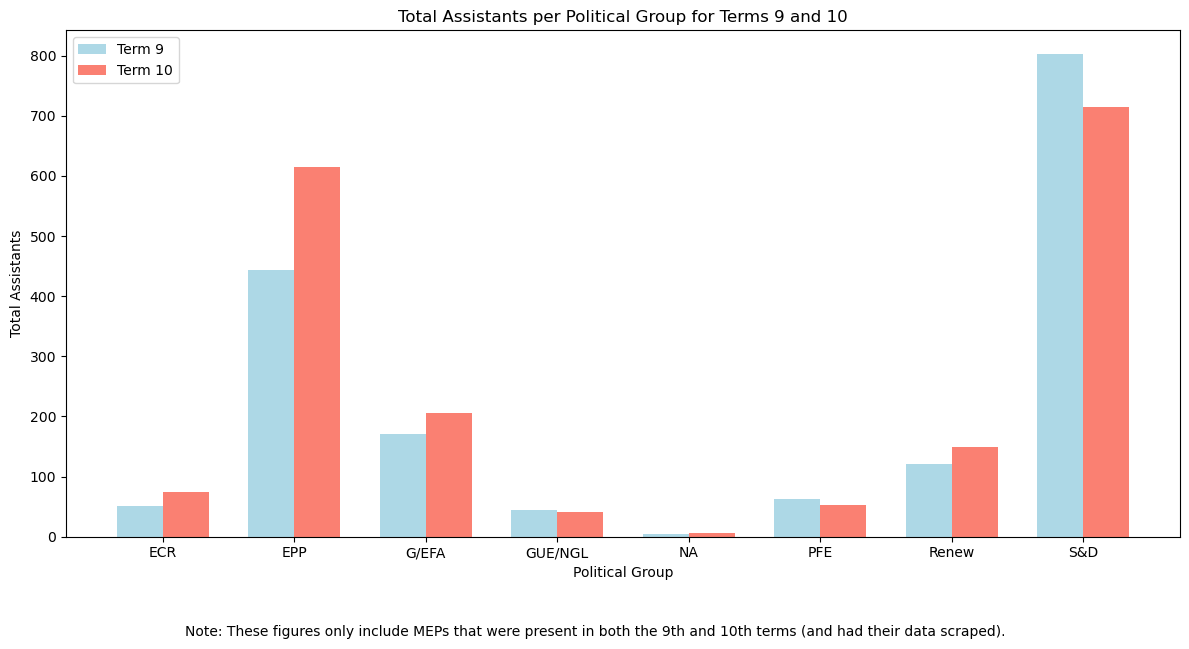

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named `group_data`
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(total_assistants))

# Create the bars
plt.bar(x, total_assistants['total_assistants_9'], width=bar_width, label='Term 9', color='lightblue')
plt.bar([p + bar_width for p in x], total_assistants['total_assistants_10'], width=bar_width, label='Term 10', color='salmon')

# Add labels and title
plt.xlabel('Political Group')
plt.ylabel('Total Assistants')
plt.title('Total Assistants per Political Group for Terms 9 and 10')
plt.xticks([p + bar_width / 2 for p in x], total_assistants['group'])
plt.legend()

# Add footnote using fig.text()
plt.gcf().text(0.5, -0.05, 
                'Note: These figures only include MEPs that were present in both the 9th and 10th terms (and had their data scraped).',
                ha='center', fontsize=10, color='black', va='top')

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
# Step 1: Filter assistants who worked for the ID group in Term 9
id_term_9 = assistants_both_terms[assistants_both_terms['group_abbr_term_9'] == 'ID']

# Step 2: Count those who stayed within the ID group in Term 10
stayed_in_id = id_term_9[id_term_9['group_abbr_term_10'] == 'ID']

# Step 3: Count those who moved to a different party in Term 10
moved_from_id = id_term_9[id_term_9['group_abbr_term_10'] != 'ID']

# Step 4: Group by the destination group and count
moved_from_id_count = moved_from_id.groupby('group_abbr_term_10').size().reset_index(name='count')

# Step 5: Calculate the total number of assistants from ID and the percentages
total_id_assistants = id_term_9.shape[0]
stayed_in_id_count = stayed_in_id.shape[0]
moved_from_id_total = moved_from_id.shape[0]

# Calculate percentages
stayed_in_id_pct = (stayed_in_id_count / total_id_assistants) * 100
moved_from_id_pct = (moved_from_id_total / total_id_assistants) * 100

# Add percentage column to the movement table
moved_from_id_count['percentage'] = (moved_from_id_count['count'] / total_id_assistants) * 100

# Step 6: Create a summary table
id_summary = pd.DataFrame({
    'category': ['Stayed in ID', 'Moved to another group'],
    'count': [stayed_in_id_count, moved_from_id_total],
    'percentage': [stayed_in_id_pct, moved_from_id_pct]
})# Step 1: Filter assistants who worked for the ID group in Term 9
id_term_9 = assistants_both_terms[assistants_both_terms['group_abbr_term_9'] == 'ID']

# Step 2: Count those who stayed within the ID group in Term 10
stayed_in_id_count = id_term_9[id_term_9['group_abbr_term_10'] == 'ID'].shape[0]

# Step 3: Count those who moved to a different party in Term 10
moved_from_id = id_term_9[id_term_9['group_abbr_term_10'] != 'ID']
moved_from_id_total = moved_from_id.shape[0]

# Step 4: Group by the destination group and count
moved_from_id_count = moved_from_id.groupby('group_abbr_term_10').size().reset_index(name='count')

# Step 5: Calculate the total number of assistants from ID and the percentages
total_id_assistants = id_term_9.shape[0]
stayed_in_id_pct = (stayed_in_id_count / total_id_assistants) * 100
moved_from_id_pct = (moved_from_id_total / total_id_assistants) * 100

# Add percentage column to the movement table
moved_from_id_count['percentage'] = (moved_from_id_count['count'] / total_id_assistants) * 100

# Step 6: Create a summary table
id_summary = pd.DataFrame({
    'category': ['Stayed in ID', 'Moved to another group'],
    'count': [stayed_in_id_count, moved_from_id_total],
    'percentage': [stayed_in_id_pct, moved_from_id_pct]
})

# Output the summary and detailed movement tables
id_summary, moved_from_id_count

(                 category  count  percentage
 0            Stayed in ID      0         0.0
 1  Moved to another group    143       100.0,
   group_abbr_term_10  count  percentage
 0                ECR     16   11.188811
 1                EPP      1    0.699301
 2                ESN     13    9.090909
 3           Patriots    113   79.020979)

# 5. Network Graphs

### 4.1 First try (old code, ignore)

In [ ]:
import networkx as nx
import plotly.graph_objects as go
import pandas as pd

# Sample Data: Replace with your actual DataFrame
# Assume `unique_meps_apas` is your DataFrame with MEPs and assistants data
# Here, the structure is: ['mep_name', 'assistant_name', 'group']

# Create a directed graph
G = nx.Graph()

# Define a color map for groups
group_colors = {
    'EPP': 'blue', 'S&D': 'red', 'Renew': 'yellow', 'Greens/EFA': 'green', 
    'ID': 'purple', 'ECR': 'orange', 'GUE/NGL': 'pink', 'NI': 'gray'
}

# Sample MEPs to visualize (You can use all unique MEPs or a subset)
sample_meps = unique_apas['mep_name'].unique()[:20]  
sample_data = unique_apas[unique_apas['mep_name'].isin(sample_meps)]

# Create a dictionary to track assistant counts for each MEP
assistant_count = {}

# Add nodes and edges based on the filtered data
for _, row in sample_data.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group']
    
    # Add MEP node with group color
    G.add_node(mep_name, type='mep', group=group, color=group_colors.get(group, 'black'))
    
    # Count assistants per MEP for sizing
    if mep_name in assistant_count:
        assistant_count[mep_name] += 1
    else:
        assistant_count[mep_name] = 1
    
    # Add edge between MEP and assistant (not needed for this visualization)
    G.add_node(assistant_name, type='assistant', color='lightgray')
    G.add_edge(mep_name, assistant_name)

# Create positions for the nodes using spring layout
pos = nx.spring_layout(G, seed=42)  # Use seed for reproducibility

# Function to format the text for MEP nodes
def format_mep_text(mep_name, count):
    if count > 1:
        # Split the name into two rows if possible
        return f"{mep_name}\n(Assistants: {count})"
    return mep_name

# Add nodes with customized sizes and colors
node_x = []
node_y = []
node_text = []
node_hover_text = []
node_size = []
node_color = []

for node in G.nodes(data=True):
    x, y = pos[node[0]]
    node_x.append(x)
    node_y.append(y)
    
    if node[1]['type'] == 'mep':
        # Set MEP node size based on the number of assistants they have
        count = assistant_count.get(node[0], 0)
        node_size.append(5 + count * 3)  # Base size plus scaling factor
        node_color.append(node[1]['color'])
        
        # Format text for the node (two lines if space allows)
        formatted_text = format_mep_text(node[0], count)
        node_text.append(formatted_text)  # Show formatted text on node
        node_hover_text.append(node[0])  # Show full name on hover
    else:
        node_size.append(0)  # Hide assistant nodes from visualization
        node_color.append('lightgray')
        node_text.append('')  # No text for assistants
        node_hover_text.append('')  # No hover text for assistants

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    hoverinfo='text',
    marker=dict(
        size=node_size,
        color=node_color,
        line=dict(width=2)
    )
)

# Create the figure with a legend
fig = go.Figure(data=[node_trace],
                layout=go.Layout(
                    title='MEP Assistants Network Graph',
                    titlefont=dict(size=16),
                    showlegend=True,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Create legend
for group, color in group_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None], 
        mode='markers', 
        marker=dict(size=10, color=color),
        name=group  # Name of the group to show in the legend
    ))

# Show the plot
fig.show()

In [ ]:
import networkx as nx
import json

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges with group, term, and assistant_type as attributes
for _, row in unique_apas.iterrows():
    # Add MEP nodes
    G.add_node(
        row['mep_name'], 
        type='mep', 
        group=row['group'], 
        term=row['term']
    )
    
    # Add assistant nodes with assistant_type
    G.add_node(
        row['assistant_name'], 
        type='assistant', 
        group=None, 
        term=None, 
        assistant_type=row.get('assistant_type')  # Ensure this attribute is populated
    )
    
    # Create edge between MEP and assistant
    G.add_edge(row['mep_name'], row['assistant_name'])

# Convert the graph to JSON format
graph_data = {
    "nodes": [
        {
            "id": node,
            "label": node,
            "type": G.nodes[node]["type"],
            "group": G.nodes[node]["group"],
            "term": G.nodes[node]["term"],
            "assistant_type": G.nodes[node].get("assistant_type")  # Add assistant_type to JSON if it exists
        }
        for node in G.nodes
    ],
    "edges": [
        {"source": source, "target": target}
        for source, target in G.edges
    ]
}

# Save to JSON file
with open("graph_data.json", "w") as f:
    json.dump(graph_data, f)

### 4.2 Pyvis Networks

#### 4.2.1 Try One

In [ ]:
import pandas as pd
from pyvis.network import Network
from IPython.core.display import display, HTML

# Assuming your DataFrame 'unique_meps_apas' is already defined

# Filter for accredited assistants
accredited_assistants = unique_apas[unique_apas['assistant_type'] == 'accredited']

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True)

# Define colors based on party/group
color_map = {
    'Renew': 'yellow', 'EPP': 'blue', 'S&D': 'red', 
    'Greens/EFA': 'green', 'ID': 'purple', 'ECR': 'orange', 
    'GUE/NGL': 'pink', 'NI': 'gray'
}

# Create a set to keep track of added nodes
added_nodes = set()

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group']
    
    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        net.add_node(mep_name, title=mep_name, color=color_map.get(group, 'black'), physics=True)
        added_nodes.add(mep_name)
    
    # Add Assistant node as a dot if it hasn't been added already
    if assistant_name not in added_nodes:
        net.add_node(assistant_name, title=assistant_name, color='lightgray', shape='dot', size=10, physics=True)
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant
    net.add_edge(mep_name, assistant_name)

# Check if any nodes or edges were added
print(f"Nodes in the network: {net.nodes}")
print(f"Edges in the network: {net.edges}")

# Set physics options for better layout
net.force_atlas_2based()
net.barnes_hut(gravity=-2000, spring_length=100, spring_strength=0.1, damping=0.6)

# Show the graph in the notebook
net.show('network.html')
#display(HTML('network.html'))

C:\Users\Emilia\AppData\Local\Temp\ipykernel_22260\1467720292.py:3: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display



Nodes in the network: [{'color': 'yellow', 'title': 'Abir AL-SAHLANI', 'physics': True, 'id': 'Abir AL-SAHLANI', 'label': 'Abir AL-SAHLANI', 'shape': 'dot'}, {'color': 'lightgray', 'title': 'Anna Sophia BENGTSSON', 'size': 10, 'physics': True, 'id': 'Anna Sophia BENGTSSON', 'label': 'Anna Sophia BENGTSSON', 'shape': 'dot'}, {'color': 'lightgray', 'title': 'John August HULTENGAARD', 'size': 10, 'physics': True, 'id': 'John August HULTENGAARD', 'label': 'John August HULTENGAARD', 'shape': 'dot'}, {'color': 'lightgray', 'title': 'Tyra Louise LUNDBERG', 'size': 10, 'physics': True, 'id': 'Tyra Louise LUNDBERG', 'label': 'Tyra Louise LUNDBERG', 'shape': 'dot'}, {'color': 'lightgray', 'title': 'Linn Christina Brunhilde OETTERLI', 'size': 10, 'physics': True, 'id': 'Linn Christina Brunhilde OETTERLI', 'label': 'Linn Christina Brunhilde OETTERLI', 'shape': 'dot'}, {'color': 'blue', 'title': 'Adam JARUBAS', 'physics': True, 'id': 'Adam JARUBAS', 'label': 'Adam JARUBAS', 'shape': 'dot'}, {'color

#### 4.2.2 Try 2 (only apas)

In [ ]:
import pandas as pd
from pyvis.network import Network
from IPython.display import display, HTML

# Filter for accredited assistants
accredited_assistants = unique_apas[unique_apas['assistant_type'] == 'accredited']

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True)

# Define enhanced colors for party/group with high contrast
color_map = {
    'Renew': '#FFD700',  # Vibrant gold
    'EPP': '#1E90FF',    # Dodger blue
    'S&D': '#FF4500',    # Orange red
    'Greens/EFA': '#32CD32',  # Lime green
    'ID': '#9400D3',     # Dark violet
    'ECR': '#FF8C00',    # Dark orange
    'GUE/NGL': '#FF1493', # Deep pink
    'NI': '#A9A9A9'      # Dark gray for non-affiliated
}

# Track added nodes and check for isolated MEP nodes
added_nodes = set()
mep_connections = {}

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group']
    
    # Track connections per MEP
    if mep_name not in mep_connections:
        mep_connections[mep_name] = 0
    
    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        net.add_node(
            mep_name, 
            title=mep_name, 
            color=color_map.get(group, '#000000'),  # Default to black if group not found
            physics=True, 
            shape='dot', 
            size=15
        )
        added_nodes.add(mep_name)
    
    # Add Assistant node as a dot if it hasn't been added already
    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name, 
            title=assistant_name, 
            color='lightgray', 
            shape='dot', 
            size=10, 
            physics=True
        )
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant, and increment connections
    net.add_edge(mep_name, assistant_name)
    mep_connections[mep_name] += 1

# Adjust isolated MEP nodes to appear on the side
for mep_name, connections in mep_connections.items():
    if connections == 0:  # No connections with other MEPs
        net.get_node(mep_name)['physics'] = False  # Fix isolated MEPs in place

# Set physics options for better layout
net.force_atlas_2based()
net.barnes_hut(gravity=-2000, spring_length=100, spring_strength=0.1, damping=0.6)

# Add a vibrant legend for the HTML
legend_html = """
<div style="position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;">
    <h4 style="margin: 0;">Legend</h4>
    <ul style="list-style-type:none; padding-left: 0;">
        <li><span style="color: #FFD700;">&#9679;</span> Renew</li>
        <li><span style="color: #1E90FF;">&#9679;</span> EPP</li>
        <li><span style="color: #FF4500;">&#9679;</span> S&D</li>
        <li><span style="color: #32CD32;">&#9679;</span> Greens/EFA</li>
        <li><span style="color: #9400D3;">&#9679;</span> ID</li>
        <li><span style="color: #FF8C00;">&#9679;</span> ECR</li>
        <li><span style="color: #FF1493;">&#9679;</span> GUE/NGL</li>
        <li><span style="color: #A9A9A9;">&#9679;</span> NI</li>
    </ul>
</div>
"""

# Save the network and add the legend to the HTML output
net.show('clustered_network.html')

clustered_network.html


#### 4.2.3 Try 3 (only apas)

In [ ]:
import pandas as pd
from pyvis.network import Network
from IPython.display import display, HTML

# Define party name mappings
party_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'Patriots',
    'Europe of Sovereign Nations Group': 'ESN'
}

# Apply party abbreviations to the dataset
accredited_assistants = unique_apas[unique_apas['assistant_type'] == 'accredited'].copy()
accredited_assistants['group'] = accredited_assistants['group'].map(party_abbreviations).fillna(accredited_assistants['group'])

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True)

# Define high-contrast colors for known groups
color_map = {
    'Renew': '#FFDD44',   
    'EPP': '#3399FF',     
    'S&D': '#FF3333',     
    'G/EFA': '#33CC33',   
    'ID': '#9933FF',      
    'ECR': '#FF9933',     
    'GUE/NGL': '#FF66B2',  
    'NA': '#808080',       
    'Patriots': '#DC143C',     
    'ESN': '#6495ED'      
}

# Track added nodes, assistants with dual terms, and MEP connections
added_nodes = set()
mep_connections = {}
dual_term_assistants = set()  # Set to track assistants serving both terms

# Identify dual-term assistants
for name, group in accredited_assistants.groupby(['mep_name', 'assistant_name']):
    terms = group['term'].unique()
    if len(terms) > 1:  # Assistant is in both terms
        dual_term_assistants.add(name[1])  # Add assistant_name to the set

# Print assistants with dual terms
print("Assistants who served in both the 9th and 10th terms:")
for assistant in dual_term_assistants:
    print(assistant)

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group']
    country = row['country']  
    term = row['term']        

    # Track connections per MEP
    if mep_name not in mep_connections:
        mep_connections[mep_name] = 0
    
    # Prepare hover title with party and country
    hover_title = f"{mep_name}Party: {group}, Country: {country}"
    
    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        net.add_node(
            mep_name, 
            title=hover_title, 
            color=color_map.get(group, '#000000'),  
            physics=True, 
            shape='dot', 
            size=15
        )
        added_nodes.add(mep_name)
    
    # Set assistant title based on term
    assistant_title = f"{assistant_name}Term: {term}"
    
    # If assistant is a dual-term assistant, update title and node size
    if assistant_name in dual_term_assistants:
        assistant_title = f"{assistant_name}Terms: 9 & 10"
        node_size = 20  # Larger size for assistants with both terms
    else:
        node_size = 10  # Default size for single-term assistants
    
    # Add Assistant node if it hasn't been added already
    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name, 
            title=assistant_title, 
            color='lightgray', 
            shape='dot', 
            size=node_size, 
            physics=True
        )
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant, and increment connections
    net.add_edge(mep_name, assistant_name)
    mep_connections[mep_name] += 1

# Adjust isolated MEP nodes to appear on the side
for mep_name, connections in mep_connections.items():
    if connections == 0:  # No connections with other MEPs
        net.get_node(mep_name)['physics'] = False  

# Set physics options for better layout
net.force_atlas_2based()
net.barnes_hut(gravity=-2000, spring_length=100, spring_strength=0.1, damping=0.6)

# Add a legend HTML with updated color map
legend_html = "<div style='position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;'>"
legend_html += "<h4 style='margin: 0;'>Legend</h4><ul style='list-style-type:none; padding-left: 0;'>"
for party, color in color_map.items():
    legend_html += f"<li><span style='color: {color};'>&#9679;</span> {party}</li>"
legend_html += "</ul></div>"

# Generate the PyVis HTML file
net.show('network_meps_apas.html')

# Add title and legend to the HTML output
with open("network_meps_apas.html", "r+") as file:
    content = file.read()
    title_html = "<h2 style='text-align: center; margin-top: 20px;'>European Parliament Accredited Assistants Network (Term 9 and 10)</h2>"
    content = title_html + legend_html + content
    file.seek(0)
    file.write(content)
    file.truncate()

Assistants who served in both the 9th and 10th terms:
Rodica NAZARI
Laurent Albert Rene GUINIOT
Nathalie Dorien VANVELTHOVEN
Rafal GASINSKI
Paul Jonas ESCHENBURG
Karl PINCHERELLE
Jeremie HABIG
Roxane Julie Sarah CHAPLAIN
Dalma FORGACS
Anna VASALOU
Petr KAROLA
Georgios TZIAPOURAS
Tsveta Rumenova RYAHOVA
Nora SEFA
Julia WAGNER
Marton KOVACS
Gerrit Bertold KRAUSE
Agnieszka PRZYBOROWICZ
Magdalena HILLS-NOWACKA
Gilles Bertrand HERAIL
Mihael Kanchev MIHOV
Sebastian KRUMKAMP
RÉMI ALEXIS CLÉMENT CARTON
Lucia DEL CASTILLO POLLAN
Elena-Catalina STEFANESCU
Dax Cornelis SLAGER
Matteo ADDUCI
Martina JANUROVA
Elena POLETTI
Nikoletta TRENKA-FARKAS
Friedrich ROESSLER
PABLO GOMEZ CEDRON
Lise Michele Claire SCHWIMMER
Kristi KAEVAND
Aude Marie Odile HOREAU
Annelot Sophie DEIBEL
Daniel Ivo PEREZ
Karin Maria KOTILAINEN
Anne-Cecile Juliette GAULT
Kyriaki MOUZAKI
Antje RITZERT
Bastien Etienne Jules RONDEAU-FRIMAS
Christian Ernesto DE MATTIA
Patrick SANDMANN
Jan Gabrielle D MORTELMANS
Lucia MELLADO CALDERON
T

#### 4.2.4 Apas grouped (with try 3 code)

In [ ]:
import pandas as pd
from pyvis.network import Network
from IPython.display import display, HTML

# Define party name mappings
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'Patriots',
    'Europe of Sovereign Nations Group': 'ESN'
}

# Apply party abbreviations to the dataset
accredited_assistants = unique_apas[unique_apas['assistant_type'] == 'accredited_grouping'].copy()
accredited_assistants['group'] = accredited_assistants['group'].map(party_abbreviations).fillna(accredited_assistants['group'])

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True)

# Define high-contrast colors for known groups
color_map = {
    'Renew': '#FFDD44',   
    'EPP': '#3399FF',     
    'S&D': '#FF3333',     
    'G/EFA': '#33CC33',   
    'ID': '#9933FF',      
    'ECR': '#FF9933',     
    'GUE/NGL': '#FF66B2',  
    'NA': '#808080',       
    'Patriots': '#DC143C',     
    'ESN': '#6495ED'      
}

# Track added nodes, assistants with dual terms, and MEP connections
added_nodes = set()
mep_connections = {}
dual_term_assistants = set()  # Set to track assistants serving both terms

# Identify dual-term assistants
for name, group in accredited_assistants.groupby(['mep_name', 'assistant_name']):
    terms = group['term'].unique()
    if len(terms) > 1:  # Assistant is in both terms
        dual_term_assistants.add(name[1])  # Add assistant_name to the set

# Print assistants with dual terms
print("Assistants who served in both the 9th and 10th terms:")
for assistant in dual_term_assistants:
    print(assistant)

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group']
    country = row['country']  
    term = row['term']        

    # Track connections per MEP
    if mep_name not in mep_connections:
        mep_connections[mep_name] = 0
    
    # Prepare hover title with party and country
    hover_title = f"{mep_name}Party: {group}, Country: {country}"
    
    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        net.add_node(
            mep_name, 
            title=hover_title, 
            color=color_map.get(group, '#000000'),  
            physics=True, 
            shape='dot', 
            size=15
        )
        added_nodes.add(mep_name)
    
    # Set assistant title based on term
    assistant_title = f"{assistant_name}Term: {term}"
    
    # If assistant is a dual-term assistant, update title and node size
    if assistant_name in dual_term_assistants:
        assistant_title = f"{assistant_name}Terms: 9 & 10"
        node_size = 20  # Larger size for assistants with both terms
    else:
        node_size = 10  # Default size for single-term assistants
    
    # Add Assistant node if it hasn't been added already
    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name, 
            title=assistant_title, 
            color='lightgray', 
            shape='dot', 
            size=node_size, 
            physics=True
        )
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant, and increment connections
    net.add_edge(mep_name, assistant_name)
    mep_connections[mep_name] += 1

# Adjust isolated MEP nodes to appear on the side
for mep_name, connections in mep_connections.items():
    if connections == 0:  # No connections with other MEPs
        net.get_node(mep_name)['physics'] = False  

# Set physics options for better layout
net.force_atlas_2based()
net.barnes_hut(gravity=-2000, spring_length=100, spring_strength=0.1, damping=0.6)

# Add a legend HTML with updated color map
legend_html = "<div style='position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;'>"
legend_html += "<h4 style='margin: 0;'>Legend</h4><ul style='list-style-type:none; padding-left: 0;'>"
for party, color in color_map.items():
    legend_html += f"<li><span style='color: {color};'>&#9679;</span> {party}</li>"
legend_html += "</ul></div>"

# Generate the PyVis HTML file
net.show('network_meps_apas_grouped.html')

# Add title and legend to the HTML output
with open("network_meps_apas_grouped.html", "r+") as file:
    content = file.read()
    title_html = "<h2 style='text-align: center; margin-top: 20px;'>European Parliament Accredited Assistants (Grouped) Network (Term 9 and 10)</h2>"
    content = title_html + legend_html + content
    file.seek(0)
    file.write(content)
    file.truncate()

KeyError: 'group'

### 4.4 BOTH APA TYPES

In [31]:
print(unique_apas.columns)
print(unique_apas['group_abbr'].unique())

Index(['assistant_name', 'mep_name', 'group_full', 'group_abbr', 'mep_party',
       'country', 'term', 'assistant_type'],
      dtype='object')
['Renew' 'EPP' 'S&D' 'ID' 'ECR' 'G/EFA' 'GUE/NGL' 'NI' 'ESN' 'Patriots']


In [43]:
import pandas as pd
from pyvis.network import Network
from IPython.display import display, HTML

# Define party name mappings
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'PfE',
    'Europe of Sovereign Nations Group': 'ESN'
}

# Apply party abbreviations to the dataset for both assistant types
accredited_assistants = unique_apas[unique_apas['assistant_type'].str.contains('accredited', na=False)].copy()
accredited_assistants['group_full'] = accredited_assistants['group_full'].map(group_abbreviations).fillna(accredited_assistants['group_full'])

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True)

# Define high-contrast colors for known groups
color_map = {
    'Renew': '#FFD700',   
    'EPP': '#3399FF',     
    'S&D': '#FF0000',     
    'G/EFA': '#009900',   
    'ID': '#2B3856',      
    'ECR': '#0054A5',     
    'GUE/NGL': '#990000',  
    'NI': '#999999',       
    'PfE': '#301C5C',     
    'ESN': '#6495ED'      
}

# Track added nodes, assistants with dual terms, and MEP connections
added_nodes = set()
mep_connections = {}
dual_term_assistants = set()  # Set to track assistants serving both terms
dual_term_meps = set()  # Set to track MEPs serving both terms

# Identify dual-term assistants and MEPs
for name, group in accredited_assistants.groupby(['mep_name', 'assistant_name']):
    terms = group['term'].unique()
    if len(terms) > 1:  # Assistant is in both terms
        dual_term_assistants.add(name[1])  # Add assistant_name to the set

for mep_name, group in accredited_assistants.groupby('mep_name'):
    terms = group['term'].unique()
    if len(terms) > 1:  # MEP is in both terms
        dual_term_meps.add(mep_name)  # Add MEP name to the set

# Print assistants and MEPs with dual terms
print("Assistants who served in both the 9th and 10th terms:")
for assistant in dual_term_assistants:
    print(assistant)

print("MEPs who served in both the 9th and 10th terms:")
for mep in dual_term_meps:
    print(mep)

# Track assistants for each MEP and MEPs for each assistant
mep_assistants = {}  # Dictionary to hold assistants for each MEP
assistant_meps = {}   # Dictionary to hold MEPs for each assistant

# Limit to 50 MEPs for testing
test_mep_limit = 50
mep_names = accredited_assistants['mep_name'].unique()[:test_mep_limit]
accredited_assistants = accredited_assistants[accredited_assistants['mep_name'].isin(mep_names)]

# Collect assistants for each MEP before adding nodes
mep_assistants = accredited_assistants.groupby('mep_name')['assistant_name'].apply(list).to_dict()

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    national_party = row['mep_party']
    assistant_name = row['assistant_name']
    group_full = row['group_full']
    group = row['group_abbr']
    country = row['country']  
    term = row['term']        

    # Track connections per MEP
    if mep_name not in mep_connections:
        mep_connections[mep_name] = 0
    
    # Add assistant to MEP's list
    if mep_name not in mep_assistants:
        mep_assistants[mep_name] = []  # Initialize list for assistants
    mep_assistants[mep_name].append(assistant_name)  # Add assistant to MEP

    # Prepare hover title for the current MEP with all their assistants
    hover_title = (
        f"{mep_name}\n"
        f"Political Group: {group_full}\n"
        f"National Party: {national_party}\n"
        f"Country: {country}\n\n"
        f"Assistants: "
    )
    assistants_list = mep_assistants.get(mep_name, [])
    hover_title += "".join([f"\n- {assistant}" for assistant in assistants_list])

    # Determine MEP node shape based on terms
    if mep_name in dual_term_meps:
        node_shape = 'star'  # MEPs who served both terms get a star shape
    elif mep_name in accredited_assistants[accredited_assistants['term'] == 9]['mep_name'].unique():
        node_shape = 'dot'  # MEPs who only served in 9th term get a circle
    else:
        node_shape = 'square'  # MEPs who only served in 10th term get a square

    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        net.add_node(
            mep_name, 
            title=hover_title, 
            color=color_map.get(group, '#000000'),  
            physics=True, 
            shape=node_shape, 
            size=15
        )
        added_nodes.add(mep_name)
    
    # Set assistant title based on term
    assistant_title = f"{assistant_name}\nTerm: {term}\n"

    # Add MEP to assistant's list
    if assistant_name not in assistant_meps:
        assistant_meps[assistant_name] = {9: [], 10: []}  # Initialize dictionary for MEPs per term (9 and 10)
    
    assistant_meps[assistant_name][term].append(mep_name)  # Add MEP to assistant's list for the corresponding term

# Add assistant nodes with the updated hover titles
for assistant_name, terms_data in assistant_meps.items():
    # Sort MEPs alphabetically for each term
    term_9_meps = sorted(terms_data[9])  # Sort MEPs for term 9
    term_10_meps = sorted(terms_data[10])  # Sort MEPs for term 10

    # Build the assistant's hover title
    assistant_title = f"{assistant_name}\n"
    if term_9_meps:
        assistant_title += f"Term 9: {', '.join(term_9_meps)}\n"
    if term_10_meps:
        assistant_title += f"Term 10: {', '.join(term_10_meps)}\n"
    
    # Determine assistant node shape based on terms
    if assistant_name in dual_term_assistants:
        node_shape = 'star'  # Assistants who served both terms get a star shape
    elif assistant_name in accredited_assistants[accredited_assistants['term'] == 9]['assistant_name'].unique():
        node_shape = 'dot'  # Assistants who only served in 9th term get a circle
    else:
        node_shape = 'square'  # Assistants who only served in 10th term get a square

    # Add Assistant node if it hasn't been added already
    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name, 
            title=assistant_title, 
            color='lightgray', 
            shape=node_shape, 
            size=10, 
            physics=True
        )
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant (add an edge for each term)
    for term in [9, 10]:
        if assistant_name in terms_data[term]:
            net.add_edge(mep_name, assistant_name)  # Make sure to add this edge to link the assistant and MEP
        
# Adjust isolated MEP nodes to appear on the side
#for mep_name, connections in mep_connections.items():
#    if connections == 0:  # No connections with other MEPs
#        net.get_node(mep_name)['physics'] = False  

# Set physics options for better layout
#net.force_atlas_2based()
#net.barnes_hut(gravity=-2000, spring_length=100, spring_strength=0.1, damping=0.6)

# Generate the PyVis HTML file
net.show('TEST_NETWORK.html')

# Add title and legend to the HTML output
with open("TEST_NETWORK.html", "r+") as file:
    content = file.read()
    title_html = "<h2 style='text-align: center; margin-top: 20px;'>European Parliament Accredited Assistants Network (Term 9 and 10)</h2>"
    
    # Create the updated legend
    legend_html = "<div style='position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;'>"
    legend_html += "<h4 style='margin: 0;'>Legend</h4><ul style='list-style-type:none; padding-left: 0;'>"
    
    # Add color mapping for political groups
    for party, color in color_map.items():
        legend_html += f"<li><span style='color: {color};'>&#9679;</span> {party}</li>"

    # Add shape mapping for terms
    legend_html += "<br><h4 style='margin: 0;'>Node Shapes</h4><ul style='list-style-type:none; padding-left: 0;'>"
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#9733;</span> Both Term 9 & Term 10</li>"  # Star for both terms
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#8226;</span> Term 9 only</li>"  # Dot for term 9 only
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#9632;</span> Term 10 only</li>"  # Square for term 10 only
    
    legend_html += "</ul></div>"
    
    # Add the title and the updated legend to the content
    content = title_html + legend_html + content
    file.seek(0)
    file.write(content)
    file.truncate()

Assistants who served in both the 9th and 10th terms:
Anna VASALOU
Christian Ernesto DE MATTIA
Mario David LOPEZ OLIVA
Juan BAYOD RODRIGO
DIMITRIOS EMMANOUIL KREMLIS
Aryaan Annabelle BOVENBERG
Coralie GUILLOT
Radoslav SOTH
JOAN SERRA MINGOT
Emilija Laima LIEPA
Ota JAKSCH
Jure TANKO
Malvina Francine Esther AMMOUN
Martin TAKACS
Gina HORST
Silver MEIKAR
Petrus Jacobus Leonard DEN BOEF
Rossana INTERLANDI
Markus MEDL
Siebe JONCKHEERE
Aude BRASTENHOFER
Elma ORUCEVIC
Diego VIUDEZ PÉREZ
Ivan FORTE
Sophie Anne Geraldine Marie GUIL
Konstantinos KALAMANTIS
Malle KUULER
Paul Ugo JEAN
David KORDON
Mai JOGIMAA
Aude Marie Odile HOREAU
Lars HAGBERG
Nikolina BRKOVIC STANCHEVA
Meeri Emilia HEINONEN
Teresa VILLA GOMEZ
Maria Isabel MEIRELES DE ANDRADE
Charlotte Julie Isabelle IZARD
Anne-Cecile Juliette GAULT
Charles KERIVEL
Cristian VILLAR PRIETO
Lucia SIMEONE
Liina LUGA
Joscha NOLLET
Elena THEVISSEN
Dax Cornelis SLAGER
Loan James Robert EGO
Justyna Anna SZCZEPANSKA
Jakub KARWANSKI
Simon Philipp BAUER
Son

# 5. NEW GRAPH CREATION

In [ ]:
import pandas as pd
from pyvis.network import Network
from IPython.display import display, HTML

# Define party name mappings
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'PfE',
    'Europe of Sovereign Nations Group': 'ESN'
}

# Apply party abbreviations to the dataset for both assistant types
accredited_assistants = unique_apas[unique_apas['assistant_type'].str.contains('accredited', na=False)].copy()
accredited_assistants['group_full'] = accredited_assistants['group_full'].map(group_abbreviations).fillna(accredited_assistants['group_full'])

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True)

# Define high-contrast colors for known groups
color_map = {
    'Renew': '#FFD700',   
    'EPP': '#3399FF',     
    'S&D': '#FF0000',     
    'G/EFA': '#009900',   
    'ID': '#2B3856',      
    'ECR': '#0054A5',     
    'GUE/NGL': '#990000',  
    'NI': '#999999',       
    'PfE': '#301C5C',     
    'ESN': '#6495ED'      
}

# Track added nodes, assistants with dual terms, and MEP connections
added_nodes = set()
mep_connections = {}
dual_term_assistants = set()  # Set to track assistants serving both terms
dual_term_meps = set()  # Set to track MEPs serving both terms

# Identify dual-term assistants and MEPs
for name, group in accredited_assistants.groupby(['mep_name', 'assistant_name']):
    terms = group['term'].unique()
    if len(terms) > 1:  # Assistant is in both terms
        dual_term_assistants.add(name[1])  # Add assistant_name to the set

for mep_name, group in accredited_assistants.groupby('mep_name'):
    terms = group['term'].unique()
    if len(terms) > 1:  # MEP is in both terms
        dual_term_meps.add(mep_name)  # Add MEP name to the set

# Print assistants and MEPs with dual terms
#print("Assistants who served in both the 9th and 10th terms:")
#for assistant in dual_term_assistants:
#    print(assistant)

#print("MEPs who served in both the 9th and 10th terms:")
#for mep in dual_term_meps:
#    print(mep)

# Track assistants for each MEP and MEPs for each assistant
mep_assistants = {}  # Dictionary to hold assistants for each MEP
assistant_meps = {}   # Dictionary to hold MEPs for each assistant

# Limit to 50 MEPs for testing
test_mep_limit = 50
mep_names = accredited_assistants['mep_name'].unique()[:test_mep_limit]
accredited_assistants = accredited_assistants[accredited_assistants['mep_name'].isin(mep_names)]

# Collect assistants for each MEP before adding nodes
mep_assistants = accredited_assistants.groupby('mep_name')['assistant_name'].apply(list).to_dict()

# Add nodes and edges to the Pyvis network
# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    national_party = row['mep_party']
    assistant_name = row['assistant_name']
    group_full = row['group_full']
    group = row['group_abbr']
    country = row['country']  
    term = row['term']        

    # Track connections per MEP
    if mep_name not in mep_connections:
        mep_connections[mep_name] = 0
    
    # Add assistant to MEP's list (not really needed anymore since we're using the `mep_assistants` dictionary now)
    if mep_name not in mep_assistants:
        mep_assistants[mep_name] = []  # Initialize list for assistants
    mep_assistants[mep_name].append(assistant_name)  # Add assistant to MEP

    # Prepare hover title for the current MEP with all their assistants
    hover_title = (
        f"{mep_name}\n"
        f"Political Group: {group_full}\n"
        f"National Party: {national_party}\n"
        f"Country: {country}\n\n"
        f"All Assistants: "
    )
    
    # Get the unique assistants for the MEP
    unique_assistants = list(set(mep_assistants.get(mep_name, [])))

    # Append only unique assistants to the hover title
    hover_title += "".join([f"\n- {assistant}" for assistant in unique_assistants])

    # Determine MEP node shape based on terms
    if mep_name in dual_term_meps:
        node_shape = 'star'  # MEPs who served both terms get a star shape
    elif mep_name in accredited_assistants[accredited_assistants['term'] == 9]['mep_name'].unique():
        node_shape = 'dot'  # MEPs who only served in 9th term get a circle
    else:
        node_shape = 'square'  # MEPs who only served in 10th term get a square

    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        net.add_node(
            mep_name, 
            title=hover_title, 
            color=color_map.get(group, '#000000'),  
            physics=True, 
            shape=node_shape, 
            size=15
        )
        added_nodes.add(mep_name)
    
    # Set assistant title based on term
    assistant_title = f"{assistant_name}\n"

    # Filter assistants by term
    assistants_term_9 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 9)]['mep_name'].tolist()
    assistants_term_10 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 10)]['mep_name'].tolist()

    assistant_title += "Term 9: " + (", ".join(assistants_term_9) if assistants_term_9 else "Did not serve") + "\n"
    assistant_title += "Term 10: " + (", ".join(assistants_term_10) if assistants_term_10 else "Did not serve")

    # If they served in both terms, show the term info for both terms
    if assistants_term_9 and assistants_term_10:
        node_shape = 'star'  # Assistants who served both terms get a star shape
    elif assistants_term_9:
        node_shape = 'dot'  # Assistants who only served in 9th term get a circle
    else:
        node_shape = 'square'  # Assistants who only served in 10th term get a square

    # Add Assistant node if it hasn't been added already
    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name, 
            title=assistant_title, 
            color='lightgray', 
            shape=node_shape, 
            size=10, 
            physics=True
        )
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant, and increment connections
    net.add_edge(mep_name, assistant_name)
    mep_connections[mep_name] += 1

# Adjust isolated MEP nodes to appear on the side
for mep_name, connections in mep_connections.items():
    if connections == 0:  # No connections with other MEPs
        net.nodes[mep_name]['x'] = 100  # Move isolated MEPs to the side
        net.nodes[mep_name]['y'] = 0

Assistants who served in both the 9th and 10th terms:
Anna VASALOU
Christian Ernesto DE MATTIA
Mario David LOPEZ OLIVA
Juan BAYOD RODRIGO
DIMITRIOS EMMANOUIL KREMLIS
Aryaan Annabelle BOVENBERG
Coralie GUILLOT
Radoslav SOTH
JOAN SERRA MINGOT
Emilija Laima LIEPA
Ota JAKSCH
Jure TANKO
Malvina Francine Esther AMMOUN
Martin TAKACS
Gina HORST
Silver MEIKAR
Petrus Jacobus Leonard DEN BOEF
Rossana INTERLANDI
Markus MEDL
Siebe JONCKHEERE
Aude BRASTENHOFER
Elma ORUCEVIC
Diego VIUDEZ PÉREZ
Ivan FORTE
Sophie Anne Geraldine Marie GUIL
Konstantinos KALAMANTIS
Malle KUULER
Paul Ugo JEAN
David KORDON
Mai JOGIMAA
Aude Marie Odile HOREAU
Lars HAGBERG
Nikolina BRKOVIC STANCHEVA
Meeri Emilia HEINONEN
Teresa VILLA GOMEZ
Maria Isabel MEIRELES DE ANDRADE
Charlotte Julie Isabelle IZARD
Anne-Cecile Juliette GAULT
Charles KERIVEL
Cristian VILLAR PRIETO
Lucia SIMEONE
Liina LUGA
Joscha NOLLET
Elena THEVISSEN
Dax Cornelis SLAGER
Loan James Robert EGO
Justyna Anna SZCZEPANSKA
Jakub KARWANSKI
Simon Philipp BAUER
Son

In [47]:
# Generate the PyVis HTML file
net.show('TEST_NETWORK.html')

# Add title and legend to the HTML output
with open("TEST_NETWORK.html", "r+") as file:
    content = file.read()
    title_html = "<h2 style='text-align: center; margin-top: 20px;'>European Parliament Accredited Assistants Network (Term 9 and 10)</h2>"
    
    # Create the updated legend
    legend_html = "<div style='position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;'>"
    legend_html += "<h4 style='margin: 0;'>Legend</h4><ul style='list-style-type:none; padding-left: 0;'>"
    
    # Add color mapping for political groups
    for party, color in color_map.items():
        legend_html += f"<li><span style='color: {color};'>&#9679;</span> {party}</li>"

    # Add shape mapping for terms
    legend_html += "<br><h4 style='margin: 0;'>Node Shapes</h4><ul style='list-style-type:none; padding-left: 0;'>"
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#9733;</span> Both Term 9 & Term 10</li>"  # Star for both terms
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#8226;</span> Term 9 only</li>"  # Dot for term 9 only
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#9632;</span> Term 10 only</li>"  # Square for term 10 only
    
    legend_html += "</ul></div>"
    
    # Add the title and the updated legend to the content
    content = title_html + legend_html + content
    file.seek(0)
    file.write(content)
    file.truncate()

TEST_NETWORK.html


# 6. AESTHEIC NETWORK GRAPH

In [81]:
from pyvis.network import Network

net = Network(height='750px', width='100%', notebook=True)

# Define the options as a JSON string (without JavaScript functions)
options = """
{
    "nodes": {
        "borderWidth": 2,
        "borderWidthSelected": 4,
        "color": {
            "border": "#2B7CE9",
            "background": "lightgray"
        },
        "font": {
            "size": 24,  
            "color": "#343434",
            "strokeWidth": 1,  
            "strokeColor": "#ffffff"  
        },
        "size": 25  
    },
    "edges": {
        "color": {
            "inherit": true
        },
        "width": 2,
        "smooth": {
            "type": "continuous"
        },
        "arrows": {
            "to": {
                "enabled": false  
            }
        }
    },
    "physics": {
        "enabled": true,
        "barnesHut": {
            "gravitationalConstant": -8000,
            "springLength": 95
        }
    },
    "layout": {
        "randomSeed": 2
    },
    "interaction": {
        "hover": true,
        "tooltipDelay": 100
    }
}
"""

# Apply the options
net.set_options(options)

# Define high-contrast colors for known groups
color_map = {
    'Renew': '#FFD700',   
    'EPP': '#3399FF',     
    'S&D': '#FF0000',     
    'G/EFA': '#009900',   
    'ID': '#2B3856',      
    'ECR': '#0054A5',     
    'GUE/NGL': '#990000',  
    'NI': '#999999',       
    'PfE': '#301C5C',     
    'ESN': '#6495ED'      
}

# Track added nodes and assistants with dual terms
added_nodes = set()

# Dictionary to store the original node and edge colors
original_node_colors = {}
original_edge_colors = {}

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group_abbr']

    # Prepare hover title for MEP with unique assistants
    hover_title = (
        f"{mep_name}\n"
        f"Group: {row['group_full']}\n"
        f"National Party: {row['mep_party']}\n"
        f"Country: {row['country']}\n"
        f"Assistants: "
    )
    
    # Ensure only unique assistants are listed for the MEP
    unique_assistants = list(set(mep_assistants.get(mep_name, [])))
    hover_title += "".join([f"\n- {assistant}" for assistant in unique_assistants])

    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        color = color_map.get(group, '#000000')
        net.add_node(
            mep_name, 
            title=hover_title, 
            color=color,
            physics=True,  # Enable physics for movement
            size=30,  # Increase node size for visibility
            shape='dot',  # Circular shape for MEPs
            label=mep_name,  # Display the MEP name
            font={'size': 20, 'color': '#FFFFFF', 'strokeWidth': 1, 'strokeColor': '#FFFFFF'}  # Make name readable
        )
        # Store the original color of the node
        original_node_colors[mep_name] = color
        added_nodes.add(mep_name)

    # Add Assistant node with term information
    assistant_title = f"{assistant_name}\n"
    assistants_term_9 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 9)]['mep_name'].tolist()
    assistants_term_10 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 10)]['mep_name'].tolist()

    assistant_title += "Term 9: " + (", ".join(assistants_term_9) if assistants_term_9 else "Did not serve") + "\n"
    assistant_title += "Term 10: " + (", ".join(assistants_term_10) if assistants_term_10 else "Did not serve")

    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name, 
            title=assistant_title, 
            color='lightgray', 
            size=15,  # Assistant nodes start with size 15
            shape='dot',  # Circular shape for assistants
            physics=True,  # Enable movement for assistant nodes
            label=assistant_name,  # Display assistant name
            font={'size': 16, 'color': '#343434', 'strokeWidth': 0, 'strokeColor': '#FFFFFF'}  # Assistant name
        )
        # Store the original color for assistants
        original_node_colors[assistant_name] = 'lightgray'
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant with increased width
    edge = net.add_edge(mep_name, assistant_name, width=2)

    # Track the original edge properties (color, width)
    edge_id = f"{mep_name}-{assistant_name}"
    original_edge_colors[edge_id] = {"color": "lightgray", "width": 2}  # Default properties

# Inject JavaScript functions for node and edge selection
js_code = """
<script type="text/javascript">
    var selectedEdge = null;
    var selectedNode = null;
    var originalEdgeColors = {};
    var originalNodeColors = {};

    // Store original edge colors and widths
    var edges = network.body.data.edges.get();
    edges.forEach(function(edge) {
        originalEdgeColors[edge.id] = {color: edge.color, width: edge.width};
    });

    var nodes = network.body.data.nodes.get();
    nodes.forEach(function(node) {
        originalNodeColors[node.id] = node.color.background;
    });

    // Function to handle edge selection
    function selectEdge(edgeId) {
        if (selectedEdge) {
            // Reset the previous edge's color and width
            network.body.data.edges.update({id: selectedEdge, color: originalEdgeColors[selectedEdge].color, width: originalEdgeColors[selectedEdge].width});
        }
        // Update the selected edge's color to bright orange and increase width to 7
        network.body.data.edges.update({id: edgeId, color: {background: 'orange', border: 'orange'}, width: 7});
        selectedEdge = edgeId;  // Store the selected edge
    }

    // Function to deselect the edge
    function deselectEdge() {
        if (selectedEdge) {
            network.body.data.edges.update({id: selectedEdge, color: originalEdgeColors[selectedEdge].color, width: originalEdgeColors[selectedEdge].width});
            selectedEdge = null;
        }
    }

    // Function to handle node selection
    function selectNode(nodeId) {
        // If the same node is selected again, deselect it
        if (selectedNode === nodeId) {
            deselectNode();
            return;
        }

        // Highlight all connected edges with bright orange color and increase width
        var connectedEdges = network.getConnectedEdges(nodeId);
        connectedEdges.forEach(function(edgeId) {
            selectEdge(edgeId);  // Call selectEdge to highlight edges
        });

        // Deselect the previously selected node (if any)
        if (selectedNode !== null) {
            deselectNode();
        }

        // Update the node's appearance when selected (thickened but not yellow for assistants)
        var originalColor = originalNodeColors[nodeId];
        if (nodeId.startsWith('assistant')) {  // If it's an assistant node
            network.body.data.nodes.update({id: nodeId, size: 15, color: {background: 'lightgray', border: '#2B7CE9'}});  // Do not turn yellow
        } else {  // MEP nodes
            network.body.data.nodes.update({id: nodeId, size: 30, color: {background: 'yellow', border: 'orange'}});
        }
        selectedNode = nodeId;  // Store the selected node
    }

    // Function to deselect node
    function deselectNode() {
        if (selectedNode) {
            // Reset the node's color to its original color and size
            network.body.data.nodes.update({id: selectedNode, size: 25, color: {background: originalNodeColors[selectedNode], border: '#2B7CE9'}});
            // Reset connected edges to original color
            var connectedEdges = network.getConnectedEdges(selectedNode);
            connectedEdges.forEach(function(edgeId) {
                deselectEdge();  // Call deselectEdge to reset edge
            });
            selectedNode = null;
        }
    }

    // Event listener for node and edge click (calls selectNode and selectEdge functions)
    network.on('click', function(params) {
        if (params.nodes.length > 0) {
            var nodeId = params.nodes[0];
            selectNode(nodeId);
        } else if (params.edges.length > 0) {
            var edgeId = params.edges[0];
            selectEdge(edgeId);
        } else {
            deselectNode();
            deselectEdge();
        }
    });
</script>
"""

# Save the network as an HTML file with custom JavaScript
net.save_graph('mep_network.html')

# Append the custom JavaScript code to the generated HTML file
with open('mep_network.html', 'a') as file:
    file.write(js_code)

# Optionally, you can display the network in the notebook
# display(net)

In [ ]:
from pyvis.network import Network

net = Network(height='750px', width='100%', notebook=True)

# Define the options as a JSON string (without JavaScript functions)
options = """
{
    "nodes": {
        "borderWidth": 2,
        "borderWidthSelected": 4,
        "color": {
            "border": "#2B7CE9",
            "background": "lightgray"
        },
        "font": {
            "size": 24,  
            "color": "#343434",
            "strokeWidth": 1,  
            "strokeColor": "#ffffff"  
        },
        "size": 25  
    },
    "edges": {
        "color": {
            "inherit": true
        },
        "width": 2,
        "smooth": {
            "type": "continuous"
        },
        "arrows": {
            "to": {
                "enabled": false  
            }
        }
    },
    "physics": {
        "enabled": true,
        "barnesHut": {
            "gravitationalConstant": -8000,
            "springLength": 95
        }
    },
    "layout": {
        "randomSeed": 2
    },
    "interaction": {
        "hover": true,
        "tooltipDelay": 100
    }
}
"""

# Apply the options
net.set_options(options)

# Define high-contrast colors for known groups
color_map = {
    'Renew': '#FFD700',   
    'EPP': '#3399FF',     
    'S&D': '#FF0000',     
    'G/EFA': '#009900',   
    'ID': '#2B3856',      
    'ECR': '#0054A5',     
    'GUE/NGL': '#990000',  
    'NI': '#999999',       
    'PfE': '#301C5C',     
    'ESN': '#6495ED'      
}

# Track added nodes and assistants with dual terms
added_nodes = set()

# Dictionary to store the original node and edge colors
original_node_colors = {}
original_edge_colors = {}

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group_abbr']

    # Prepare hover title for MEP with unique assistants
    hover_title = (
        f"{mep_name}\n"
        f"Group: {row['group_full']}\n"
        f"National Party: {row['mep_party']}\n"
        f"Country: {row['country']}\n"
        f"Assistants: "
    )
    
    # Ensure only unique assistants are listed for the MEP
    unique_assistants = list(set(mep_assistants.get(mep_name, [])))
    hover_title += "".join([f"\n- {assistant}" for assistant in unique_assistants])

    # Add MEP node if it hasn't been added already
    if mep_name not in added_nodes:
        color = color_map.get(group, '#000000')
        net.add_node(
            mep_name, 
            title=hover_title, 
            color=color,
            physics=True,  # Enable physics for movement
            size=30,  # Increase node size for visibility
            shape='dot',  # Circular shape for MEPs
            label=mep_name,  # Display the MEP name
            font={'size': 20, 'color': '#FFFFFF', 'strokeWidth': 1, 'strokeColor': '#FFFFFF'}  # Make name readable
        )
        # Store the original color of the node
        original_node_colors[mep_name] = color
        added_nodes.add(mep_name)

    # Add Assistant node with term information
    assistant_title = f"{assistant_name}\n"
    assistants_term_9 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 9)]['mep_name'].tolist()
    assistants_term_10 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 10)]['mep_name'].tolist()

    assistant_title += "Term 9: " + (", ".join(assistants_term_9) if assistants_term_9 else "Did not serve") + "\n"
    assistant_title += "Term 10: " + (", ".join(assistants_term_10) if assistants_term_10 else "Did not serve")

    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name, 
            title=assistant_title, 
            color='lightgray', 
            size=15,  # Assistant nodes start with size 15
            shape='dot',  # Circular shape for assistants
            physics=True,  # Enable movement for assistant nodes
            label=assistant_name,  # Display assistant name
            font={'size': 16, 'color': '#343434', 'strokeWidth': 0, 'strokeColor': '#FFFFFF'}  # Assistant name
        )
        # Store the original color for assistants
        original_node_colors[assistant_name] = 'lightgray'
        added_nodes.add(assistant_name)

    # Add edge between MEP and assistant with increased width
    edge = net.add_edge(mep_name, assistant_name, width=2)

    # Track the original edge properties (color, width)
    edge_id = f"{mep_name}-{assistant_name}"
    original_edge_colors[edge_id] = {"color": "lightgray", "width": 2}  # Default properties

# Inject JavaScript functions for node and edge selection
js_code = """
<script type="text/javascript">
    var selectedNodes = [];
    var selectedEdges = [];

    var originalEdgeColors = {};
    var originalNodeColors = {};

    // Store original edge colors and widths
    var edges = network.body.data.edges.get();
    edges.forEach(function(edge) {
        originalEdgeColors[edge.id] = {color: edge.color, width: edge.width};
    });

    var nodes = network.body.data.nodes.get();
    nodes.forEach(function(node) {
        originalNodeColors[node.id] = node.color.background;
    });

    // Function to handle node selection
    function selectNode(nodeId) {
        // If node is already selected, do nothing
        if (selectedNodes.includes(nodeId)) return;

        // Add node to the selected nodes list
        selectedNodes.push(nodeId);

        // Highlight all connected edges with bright orange color and increase width to 7
        var connectedEdges = network.getConnectedEdges(nodeId);
        connectedEdges.forEach(function(edgeId) {
            network.body.data.edges.update({id: edgeId, color: {background: 'orange', border: 'orange'}, width: 7});
        });

        // Update the node's appearance when selected (thickened but not yellow for assistants)
        var originalColor = originalNodeColors[nodeId];
        if (nodeId.startsWith('assistant')) {  // If it's an assistant node
            network.body.data.nodes.update({id: nodeId, size: 15, color: {background: 'lightgray', border: '#2B7CE9'}});  // Do not turn yellow
        } else {  // MEP nodes
            network.body.data.nodes.update({id: nodeId, size: 35, color: {background: originalColor, border: originalColor}});
        }
    }

    // Function to deselect all nodes and edges
    function deselectAll() {
        // Reset all selected nodes and edges
        selectedNodes.forEach(function(nodeId) {
            var originalColor = originalNodeColors[nodeId];
            network.body.data.nodes.update({id: nodeId, size: 25, color: {background: originalColor, border: originalColor}});
            
            var connectedEdges = network.getConnectedEdges(nodeId);
            connectedEdges.forEach(function(edgeId) {
                network.body.data.edges.update({id: edgeId, color: originalEdgeColors[edgeId].color, width: originalEdgeColors[edgeId].width});
            });
        });

        // Clear the selected nodes and edges
        selectedNodes = [];
        selectedEdges = [];
    }

    // Add event listeners for node and edge clicks
    network.on("click", function(event) {
        if (event.nodes.length === 0 && event.edges.length === 0) {
            deselectAll();  // Deselect if the click is not on any node or edge
        } else if (event.nodes.length > 0) {
            selectNode(event.nodes[0]);  // Select node
        } else if (event.edges.length > 0) {
            selectEdge(event.edges[0]);  // Select edge
        }
    });

    // Function to handle edge selection
    function selectEdge(edgeId) {
        network.body.data.edges.update({id: edgeId, color: {background: 'orange', border: 'orange'}, width: 7});  // Turn orange and thickened
        // Highlight all connected edges
        var connectedEdges = network.getConnectedEdges(edgeId);
        connectedEdges.forEach(function(eId) {
            network.body.data.edges.update({id: eId, color: {background: 'orange', border: 'orange'}, width: 7});
        });
    }
</script>
"""

# Save the network as an HTML file with custom JavaScript
net.save_graph('mep_network.html')

# Append the custom JavaScript code to the generated HTML file
with open('mep_network.html', 'a') as file:
    file.write(js_code)

# FINAL GRAPH CODE

In [ ]:
import pandas as pd
from pyvis.network import Network
from IPython.display import display, HTML

# Define party name mappings
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'PfE',
    'Europe of Sovereign Nations Group': 'ESN'
}

# Apply party abbreviations to the dataset for both assistant types
accredited_assistants = unique_apas[unique_apas['assistant_type'].str.contains('accredited', na=False)].copy()
accredited_assistants['group_full'] = accredited_assistants['group_full'].map(group_abbreviations).fillna(accredited_assistants['group_full'])

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True)

# Define high-contrast colors for known groups
color_map = {
    'Renew': '#FFD700',
    'EPP': '#3399FF',
    'S&D': '#FF0000',
    'G/EFA': '#009900',
    'ID': '#2B3856',
    'ECR': '#0054A5',
    'GUE/NGL': '#990000',
    'NA': '#999999',
    'PfE': '#301C5C',
    'ESN': '#6495ED'
}

added_nodes = set()
mep_connections = {}
mep_assistants = accredited_assistants.groupby('mep_name')['assistant_name'].apply(list).to_dict()

# Identify isolated nodes (nodes with no edges)
for mep_name, group in accredited_assistants.groupby('mep_name'):
    if len(group) == 0:
        mep_connections[mep_name] = 0

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    national_party = row['mep_party']
    assistant_name = row['assistant_name']
    group_full = row['group_full']
    group = row['group_abbr']
    country = row['country']
    term = row['term']

    hover_title = (
        f"{mep_name}\n"
        f"Political Group: {group_full}\n"
        f"National Party: {national_party}\n"
        f"Country: {country}\n\n"
        f"All Assistants: " + "".join([f"\n- {assistant}" for assistant in list(set(mep_assistants.get(mep_name, [])))])
    )

    node_shape = 'star' if term > 9 else 'dot'
    color = color_map.get(group, '#000000')

    if mep_name not in added_nodes:
        physics_enabled = mep_connections.get(mep_name, 0) > 0
        net.add_node(
            mep_name,
            title=hover_title,
            color=color,
            physics=physics_enabled,
            shape=node_shape,
            size=28
        )
        added_nodes.add(mep_name)

    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name,
            title=assistant_name,
            color='lightgray',
            shape='dot',
            size=17,
            physics=True
        )
        added_nodes.add(assistant_name)

    net.add_edge(mep_name, assistant_name)

# Apply force atlas 2-based physics options
net.force_atlas_2based(
    gravity=-2000,
    central_gravity=0.005,
    spring_length=100,
    spring_strength=0.1,
    damping=0.6,
    overlap=0
)

# JavaScript for interactive filtering
options = """
<script type="text/javascript">
    function filterByGroup(group) {
        const allNodes = network.body.data.nodes.get();
        const filteredNodes = allNodes.filter(node => node.group === group || group === 'all');
        const allEdges = network.body.data.edges.get();
        const filteredEdges = allEdges.filter(edge => 
            filteredNodes.some(node => node.id === edge.from) &&
            filteredNodes.some(node => node.id === edge.to)
        );

        network.setData({ nodes: new vis.DataSet(filteredNodes), edges: new vis.DataSet(filteredEdges) });
    }
</script>
"""

# Add filtering dropdown
dropdown_html = """
<select onchange="filterByGroup(this.value)">
    <option value="all">Show All</option>
    <option value="Renew">Renew</option>
    <option value="EPP">EPP</option>
    <option value="S&D">S&D</option>
    <option value="G/EFA">G/EFA</option>
    <option value="ID">ID</option>
    <option value="ECR">ECR</option>
    <option value="GUE/NGL">GUE/NGL</option>
    <option value="NA">Non-attached</option>
    <option value="PfE">PfE</option>
    <option value="ESN">ESN</option>
</select>
"""

# Set options and save the graph
net.set_options(options)
net.save_graph('mep_network.html')

# Display the generated HTML with dropdown
html_output = f"{dropdown_html}<iframe src='mep_network.html' width='100%' height='750px'></iframe>"
display(HTML(html_output))


# Set physics options for better layout
net.force_atlas_2based()
net.barnes_hut(gravity=-2000, spring_length=100, spring_strength=0.1, damping=0.6)


In [109]:
# Add title and legend to the HTML output
with open("mep_network.html", "r+") as file:
    content = file.read()
    title_html = "<h2 style='text-align: center; margin-top: 20px;'>European Parliament Accredited Assistants Network (Term 9 and 10)</h2>"
    
    # Create the updated legend
    legend_html = "<div style='position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;'>"
    legend_html += "<h4 style='margin: 0;'>Legend</h4><ul style='list-style-type:none; padding-left: 0;'>"
    
    # Add color mapping for political groups
    for party, color in color_map.items():
        legend_html += f"<li><span style='color: {color};'>&#9679;</span> {party}</li>"

    # Add shape mapping for terms
    legend_html += "<br><h4 style='margin: 0;'>Node Shapes</h4><ul style='list-style-type:none; padding-left: 0;'>"
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#9733;</span> Both Term 9 & Term 10</li>"  # Star for both terms
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#8226;</span> Term 9 only</li>"  # Dot for term 9 only
    legend_html += "<li><span style='color: black; font-size: 20px; padding-right: 5px;'>&#9632;</span> Term 10 only</li>"  # Square for term 10 only
    
    legend_html += "</ul></div>"
    
    # Add the title and the updated legend to the content
    content = title_html + legend_html + content
    file.seek(0)
    file.write(content)
    file.truncate()

In [112]:
import pandas as pd
from pyvis.network import Network

# Define party name mappings
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'PfE',
    'Europe of Sovereign Nations Group': 'ESN'
}

# Apply party abbreviations to the dataset
accredited_assistants = unique_apas[unique_apas['assistant_type'].str.contains('accredited', na=False)].copy()
accredited_assistants['group_full'] = accredited_assistants['group_full'].map(group_abbreviations).fillna(accredited_assistants['group_full'])

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=False)

# Define colors for political groups
color_map = {
    'Renew': '#FFD700',
    'EPP': '#3399FF',
    'S&D': '#FF0000',
    'G/EFA': '#009900',
    'ID': '#2B3856',
    'ECR': '#0054A5',
    'GUE/NGL': '#990000',
    'NA': '#999999',
    'PfE': '#301C5C',
    'ESN': '#6495ED'
}

added_nodes = set()
dual_term_assistants = set()
dual_term_meps = set()

# Identify dual-term assistants and MEPs
for name, group in accredited_assistants.groupby(['mep_name', 'assistant_name']):
    terms = group['term'].unique()
    if len(terms) > 1:
        dual_term_assistants.add(name[1])

for mep_name, group in accredited_assistants.groupby('mep_name'):
    terms = group['term'].unique()
    if len(terms) > 1:
        dual_term_meps.add(mep_name)

mep_assistants = accredited_assistants.groupby('mep_name')['assistant_name'].apply(list).to_dict()

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    national_party = row['mep_party']
    assistant_name = row['assistant_name']
    group_full = row['group_full']
    group = row['group_abbr']
    country = row['country']
    term = row['term']

    hover_title = (
        f"{mep_name}\n"
        f"Political Group: {group_full}\n"
        f"National Party: {national_party}\n"
        f"Country: {country}\n\n"
        f"All Assistants: "
    )
    unique_assistants = list(set(mep_assistants.get(mep_name, [])))
    hover_title += "".join([f"\n- {assistant}" for assistant in unique_assistants])

    # Determine node shape for MEPs
    if mep_name in dual_term_meps:
        node_shape = 'star'
    elif term == 10:
        node_shape = 'square'
    else:
        node_shape = 'dot'

    if mep_name not in added_nodes:
        net.add_node(
            mep_name,
            title=hover_title,
            color=color_map.get(group, '#000000'),
            physics=True,
            shape=node_shape,
            size=28
        )
        added_nodes.add(mep_name)

    assistants_term_9 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 9)]['mep_name'].tolist()
    assistants_term_10 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 10)]['mep_name'].tolist()

    # Restore original assistant hover title
    assistant_title = f"{assistant_name}\n"
    assistant_title += "Term 9: " + (", ".join(assistants_term_9) if assistants_term_9 else "Did not serve") + "\n"
    assistant_title += "Term 10: " + (", ".join(assistants_term_10) if assistants_term_10 else "Did not serve")

    # Determine node shape for assistants
    if assistants_term_9 and assistants_term_10:
        node_shape = 'star'
    elif assistants_term_10:
        node_shape = 'square'
    else:
        node_shape = 'dot'

    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name,
            title=assistant_title,
            color='lightgray',
            shape=node_shape,
            size=17,
            physics=True
        )
        added_nodes.add(assistant_name)

    # Add edges between MEPs and their assistants
    net.add_edge(mep_name, assistant_name)

# Apply force atlas 2-based physics
net.force_atlas_2based(
    gravity=-2000,
    spring_length=100,
    spring_strength=0.1,
    damping=0.6,
)

# Save the graph to an HTML file
net.save_graph('mep_network_filter.html')

# Add title and legend to the HTML output
with open("mep_network_filter.html", "r+") as file:
    content = file.read()
    title_html = "<h2 style='text-align: center; margin-top: 20px;'>European Parliament Accredited Assistants Network (Term 9 and 10)</h2>"

    legend_html = "<div style='position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;'>"
    legend_html += "<h4 style='margin: 0;'>Legend</h4><ul style='list-style-type:none; padding-left: 0;'>"
    for party, color in color_map.items():
        legend_html += f"<li><span style='color: {color};'>&#9679;</span> {party}</li>"

    legend_html += "<br><h4 style='margin: 0;'>Node Shapes</h4><ul style='list-style-type:none; padding-left: 0;'>"
    legend_html += "<li><span style='color: black; font-size: 20px;'>&#9733;</span> Both Term 9 & Term 10</li>"
    legend_html += "<li><span style='color: black; font-size: 20px;'>&#9632;</span> Term 10 only</li>"
    legend_html += "<li><span style='color: black; font-size: 20px;'>&#8226;</span> Term 9 only</li>"
    legend_html += "</ul></div>"

    content = title_html + legend_html + content
    file.seek(0)
    file.write(content)
    file.truncate()

print("Graph saved as 'mep_network_filter.html'. Please open the file manually to view the network.")

Graph saved as 'mep_network_filter.html'. Please open the file manually to view the network.


# praying for last

In [121]:
import pandas as pd
from pyvis.network import Network

# Define test mode
test_mode = False  # Set to False to use the full dataset

# Define party name mappings
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'PfE',
    'Europe of Sovereign Nations Group': 'ESN'
}

# Apply party abbreviations to the dataset
accredited_assistants = unique_apas[unique_apas['assistant_type'].str.contains('accredited', na=False)].copy()
accredited_assistants['group_full'] = accredited_assistants['group_full'].map(group_abbreviations).fillna(accredited_assistants['group_full'])

# Use a smaller subset for testing if in test mode
if test_mode:
    print("Test mode enabled: Using the first 400 rows for testing.")
    accredited_assistants = accredited_assistants.tail(500)
else:
    print("Full mode enabled: Using the entire dataset.")

# Create a Pyvis network graph
net = Network(height='900px', width='100%', notebook=False, directed=False)

# Define colors for political groups
color_map = {
    'Renew': '#FFD700',
    'EPP': '#3399FF',
    'S&D': '#FF0000',
    'G/EFA': '#009900',
    'ID': '#2B3856',
    'ECR': '#0054A5',
    'GUE/NGL': '#990000',
    'NA': '#999999',
    'PfE': '#301C5C',
    'ESN': '#6495ED'
}

added_nodes = set()
dual_term_assistants = set()
dual_term_meps = set()

# Identify dual-term assistants and MEPs
for name, group in accredited_assistants.groupby(['mep_name', 'assistant_name']):
    terms = group['term'].unique()
    if 9 in terms and 10 in terms:
        dual_term_assistants.add(name[1])

for mep_name, group in accredited_assistants.groupby('mep_name'):
    terms = group['term'].unique()
    if 9 in terms and 10 in terms:
        dual_term_meps.add(mep_name)

mep_assistants = accredited_assistants.groupby('mep_name')['assistant_name'].apply(list).to_dict()

# Add nodes and edges to the Pyvis network
for _, row in accredited_assistants.iterrows():
    mep_name = row['mep_name']
    national_party = row['mep_party']
    assistant_name = row['assistant_name']
    group_full = row['group_full']
    term = row['term']

    hover_title = (
        f"{mep_name}\n"
        f"Political Group: {group_full}\n"
        f"National Party: {national_party}\n\n"
        f"All Assistants: "
    )
    unique_assistants = list(set(mep_assistants.get(mep_name, [])))
    hover_title += "".join([f"\n- {assistant}" for assistant in unique_assistants])

    # Determine MEP node shape
    if mep_name in dual_term_meps:
        node_shape = 'star'
    elif term == 10:
        node_shape = 'square'
    else:
        node_shape = 'dot'

    node_size = 40 if mep_name in dual_term_meps else 30

    if mep_name not in added_nodes:
        net.add_node(
            mep_name,
            title=hover_title,
            color=color_map.get(group_full, '#000000'),
            physics=True,
            shape=node_shape,
            size=node_size,
            label=mep_name
        )
        added_nodes.add(mep_name)

    # Determine assistant hover title
    assistants_term_9 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 9)]['mep_name'].tolist()
    assistants_term_10 = accredited_assistants[(accredited_assistants['assistant_name'] == assistant_name) & (accredited_assistants['term'] == 10)]['mep_name'].tolist()

    assistant_title = f"{assistant_name}\n"
    assistant_title += "Term 9: " + (", ".join(assistants_term_9) if assistants_term_9 else "Did not serve") + "\n"
    assistant_title += "Term 10: " + (", ".join(assistants_term_10) if assistants_term_10 else "Did not serve")

    # Determine assistant node shape
    if assistant_name in dual_term_assistants:
        assistant_shape = 'star'
    elif assistants_term_10:
        assistant_shape = 'square'
    else:
        assistant_shape = 'dot'

    if assistant_name not in added_nodes:
        net.add_node(
            assistant_name,
            title=assistant_title,
            color='lightgray',
            shape=assistant_shape,
            size=20,
            physics=True,
            label=' '  # No label for assistant nodes
        )
        added_nodes.add(assistant_name)

    # Add edges between MEPs and their assistants
    net.add_edge(mep_name, assistant_name)

# Apply force atlas 2-based physics
net.force_atlas_2based(
    gravity=-2500,
    spring_length=150,
    spring_strength=0.2,
    damping=0.7,
)

# Save the graph to an HTML file
net.save_graph('mep_network_TEST.html')

# Inject filter, title, and legend
with open("mep_network_TEST.html", "r+") as file:
    content = file.read()
    # Title HTML
    title_html = "<h2 style='text-align: center; margin-top: 20px;'>European Parliament Accredited Assistants Network (Term 9 and 10)</h2>"

    # Legend HTML
    legend_html = "<div style='position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;'>"
    legend_html += "<h4 style='margin: 0;'>Legend</h4><ul style='list-style-type:none; padding-left: 0;'>"
    for party, color in color_map.items():
        legend_html += f"<li><span style='color: {color};'>&#9679;</span> {party}</li>"

    # Node Shapes Legend
    legend_html += "<br><h4 style='margin: 0;'>Node Shapes</h4><ul style='list-style-type:none; padding-left: 0;'>"
    legend_html += "<li><span style='color: black; font-size: 20px;'>&#9733;</span> Both Term 9 & Term 10</li>"
    legend_html += "<li><span style='color: black; font-size: 20px;'>&#9632;</span> Term 10 only</li>"
    legend_html += "<li><span style='color: black; font-size: 20px;'>&#8226;</span> Term 9 only</li>"
    legend_html += "</ul></div>"
    
    #Filter html
    filter_html = """
    <div style='position: absolute; bottom: 10px; left: 10px; background-color: white; padding: 10px; border: 1px solid #ccc; z-index: 1000;'>
        <label for='shapeFilter'>Filter by Term:</label>
        <select id='shapeFilter'>
            <option value='star'>Both Terms</option>
            <option value='square'>10th Term</option>
            <option value='dot'>9th Term</option>
        </select>
    </div>
    <script>
        const shapeFilter = document.getElementById('shapeFilter');
        shapeFilter.addEventListener('change', function() {
            const selectedShape = shapeFilter.value;
            network.body.data.nodes.update(network.body.data.nodes.get().map(node => {
                node.hidden = selectedShape !== 'all' && node.shape !== selectedShape;
                return node;
            }));
        });
    </script>
    """
    content = content.replace("</body>", title_html + legend_html + filter_html + "</body>")
    file.seek(0)
    file.write(content)
    file.truncate()

print("Graph saved as 'mep_network_TEST.html'. Please open the file manually to view the network.")

Full mode enabled: Using the entire dataset.
Graph saved as 'mep_network_TEST.html'. Please open the file manually to view the network.


### 4.3 Dash Network

In [ ]:
import pandas as pd
import dash
from dash import dcc, html, Input, Output
import dash_cytoscape as cyto

# Filter for accredited assistants
accredited_assistants = unique_apas[unique_apas['assistant_type'] == 'accredited']

# Define colors based on party/group
color_map = {
    'Renew': '#FFFF00',  # yellow
    'EPP': '#0000FF',    # blue
    'S&D': '#FF0000',     # red
    'Greens/EFA': '#00FF00',  # green
    'ID': '#800080',      # purple
    'ECR': '#FFA500',     # orange
    'GUE/NGL': '#FFC0CB',  # pink
    'NI': '#808080'       # gray
}

# Create Dash application
app = dash.Dash(__name__)

# Create the layout for the Dash app
app.layout = html.Div([
    dcc.Dropdown(
        id='group-filter',
        options=[{'label': group, 'value': group} for group in color_map.keys()],
        multi=True,
        value=list(color_map.keys()),  # Show all by default
        placeholder="Select groups to filter"
    ),
    cyto.Cytoscape(
        id='network-graph',
        layout={'name': 'cose'},
        style={'width': '100%', 'height': '750px'},
        elements=[],  # Will be populated dynamically
        stylesheet=[
            {'selector': 'node', 'style': {'label': 'data(label)', 'background-color': 'data(color)'}},
            {'selector': 'edge', 'style': {'width': 1, 'line-color': '#ccc'}}
        ],
    )
])

@app.callback(
    Output('network-graph', 'elements'),
    Input('group-filter', 'value')
)
def update_graph(selected_groups):
    # Prepare elements for Cytoscape
    elements = []

    # Add MEPs and Assistants
    for _, row in accredited_assistants.iterrows():
        mep_name = row['mep_name']
        assistant_name = row['assistant_name']
        group = row['group']

        # Add MEP nodes
        if group in selected_groups:
            elements.append({
                'data': {'id': mep_name, 'label': mep_name, 'color': color_map.get(group, '#000')},
                'position': {'x': 0, 'y': 0}  # Positioning can be managed with layout
            })

            # Add Assistant nodes
            elements.append({
                'data': {'id': assistant_name, 'label': assistant_name, 'color': '#D3D3D3'},  # Light gray for assistants
                'position': {'x': 0, 'y': 0}
            })

            # Add edges
            elements.append({
                'data': {'source': mep_name, 'target': assistant_name}
            })

    # If an MEP has no connections, add them to the graph
    for mep in unique_apas['mep_name'].unique():
        if mep not in accredited_assistants['mep_name'].values:
            elements.append({
                'data': {'id': mep, 'label': mep, 'color': color_map.get(row['group'], '#000')},
                'position': {'x': 0, 'y': 0}  # Separate position for isolated MEPs
            })

    return elements

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)